<b>Data mining project - 2020/21</b><br>
<b>Authors</b>: [Alexandra Bradan](https://github.com/alexandrabradan), [Marianna Abbattista](https://github.com/Mariabba), [Eleonora Cocciu](https://github.com/eleonoracocciu) and [Dafina Leva](https://github.com/dafina-95)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 20/11/2020<b>

In [126]:
%matplotlib inline

# general libraries
import sys
import math
import collections
import missingno as msno
from pylab import MaxNLocator
from collections import defaultdict

# pandas libraries
import pandas as pd
from pandas import DataFrame
from pandas.testing import assert_frame_equal

# visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

# numpy libraries
import numpy as np
from numpy import std
from numpy import mean
from numpy import percentile

# scipy libraries
import scipy.stats as stats
from scipy.stats import kstest
from scipy.stats import normaltest

# sklearn libraries
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer  # explicitly require this experimental feature
from sklearn.impute import IterativeImputer

In [128]:
data_directory = "../../../data/"
plot_directory = "../../../plots/DataUnderstanding/"
TR_file = data_directory + "Train_HR_Employee_Attrition.csv"
TS_file = data_directory + "Test_HR_Employee_Attrition.csv"
impunted_TR_file = data_directory + "Impunted_Train_HR_Employee_Attrition.csv"
clean_TR_file = data_directory + "Cleaned_Train_HR_Employee_Attrition.csv"
clean_norm_TR_file = data_directory + "Cleaned_Normalized_Train_HR_Employee_Attrition.csv"
num_norm_TR_file = data_directory + "Numerical_Normalized_Train_HR_Employee_Attrition.csv"
cat_norm_TR_file = data_directory + "Categorical_Normalized_Train_HR_Employee_Attrition.csv"
num_TR_file = data_directory + "Numerical_Train_HR_Employee_Attrition.csv"
cat_TR_file = data_directory + "Categorical_Train_HR_Employee_Attrition.csv"

In [129]:
df_num = pd.read_csv(num_norm_TR_file) 
df_impunted = pd.read_csv(impunted_TR_file)

In [130]:
df_num.head()

Age  DistanceFromHome  MonthlyIncome  PercentSalaryHike  \
0  0.809524          0.285714       0.286171           0.428571   
1  0.428571          0.000000       0.147183           0.214286   
2  0.166667          0.535714       0.144644           1.000000   
3  0.357143          0.142857       0.068878           0.214286   
4  0.309524          0.285714       0.204325           0.071429   

   StockOptionLevel  TrainingTimesLastYear  YearsAtCompany  \
0          0.000000               0.333333            0.40   
1          0.333333               0.500000            0.05   
2          0.333333               0.666667            0.05   
3          0.000000               0.166667            0.15   
4          0.000000               0.333333            0.50   

   YearsInCurrentRole  MonthlyHours  Attrition  OverTime  OverallSatisfaction  \
0              0.4375      0.231122        0.0       0.0             0.333333   
1              0.5000      0.233476        0.0       1.0             0.333333   
2              0.3125      0.747017        0.0       1.0             0.666667   
3              0.4375      0.435214        0.0       0.0             0.333333   
4              0.1250      0.142192        0.0       0.0             0.666667   

   JobLevel  NumCompaniesWorked  Education  
0      0.50            1.000000       0.75  
1      1.00            0.111111       0.00  
2      0.25            0.111111       0.50  
3      0.00            0.222222       0.75  
4      0.00            0.111111       0.25

In [131]:
df_probe = df_num.copy()

<h2> Hierarchical clustering </h2>
Hierarchical approaches to clustering are useful when having an nested structure among the cluster is a necessity. The main drawbacks of such approaches are the time and space performances and, for this reasons, they're usually combined with other clustering analysis like k-means.

The hierarchy of clusters can be visualized with a dendogram: a tree structure where the horizontal lines represent the merging of two nodes, or clusters, and the vertical line provides information regarding the distance (or similarity) between said elements. By the end of the agglomerative bottom-up process, the dendrogram ends up displaying the whole merging process leading to a single universal cluster. Every number of clusters can be obtained by cutting the tree at the right level / height.


The first step is to compute the matrix accounting the distances among each of the point in our dataframe. Said computing can be performed by the <b>scipy.spatial.distance</b> function <b>pdist</b> or by specifying a particulare metric as a parameter of the <b>AgglomerativeClustering</b> class of <b>sklearn.cluster</b>.

Both alternatives are able to compute distances with respect to several well-known metrics or even custom ones specifically defined by the user. For the sake of this analysis, and due to the rich presence of continuous numerical data, we are going to select the <b>Euclidean distance as our metrics of choice</b>.

The second step is usually to chose a linkage method, that is chosing how the computation of the aforementioned distance is going to be performed. Again, the list of methods for linkage contains several choices, mainly leading to:

- Max / Complete-Linkage
- Min / Single-linkage
- Average-linkage
- Ward-linkage

We are going to analize and discuss the application of these main methods.

Optimal value of k in hierarchical clustering

Hiearchical approaches don't usually provide, at least explicity, an ideal number of clusters. 
The <b>best "cut" for the dendrogram is placed at a height where the line can traverse the maximum distance without intersecting an horizontal line</b> representing a merging point. Said method, however, is not perfect and the selection of an optimal k is often influenced by the characteristics of the dataset or the application of the clustering itself. Also, the <b>dendrogram function from scipy</b>, thanks to the <u>color_threshold</u> parameter, is able to highlight with different colors the links connecting nodes particularly close to each other, hence providing a powerful insight regarding the main clusters whitin the dataset.

In [132]:
from scipy.cluster.hierarchy import dendrogram, linkage, centroid, fcluster, cut_tree
from scipy.spatial.distance import pdist

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [133]:
def draw_silhouette(k, silhouette, method):
    # Create two subplots and unpack the output array immediately
    f, axs = plt.subplots(figsize=(5, 5))
    
    axs.plot(k, silhouette)
    plt.xlabel('K')
    plt.ylabel('SIL')
    plt.title('Silhouette Score for ' + str(method) + "-linkage")
    plt.show()

In [134]:
def interpret_dendogram(method):
    k = list(range(2, 13))
    silhouette = []
    for i in k:
        complete = AgglomerativeClustering(n_clusters=i, linkage=method, affinity='euclidean', connectivity=None)
        complete.fit(df_probe)
        hist, bins = np.histogram(complete.labels_, bins=range(0, len(set(complete.labels_)) + 1))

        print('Cluster numbers: ', i)
        print('Cluster', dict(zip(bins, hist)))
        print('Silhouette Score', silhouette_score(df_probe, complete.labels_))
        silhouette.append(silhouette_score(df_probe, complete.labels_))
        
    draw_silhouette(k, silhouette, method)

In [135]:
def plot_dendrogram(model, cut_distance, linkage_mode, **kwargs):
    """
        Function which creates the linkage matrix (proximity/similarity matrix),
        with which plots the cooresponding obtained dendrogram.
    """
    # children_ = children of each non-leaf node
    # N.B. A node i greater than or equal to n_samples is a non-leaf node 
    # and has children children_[i - n_samples], with n_samples = len(labels_)
    counts = np.zeros(model.children_.shape[0])  
    n_samples = len(model.labels_) # labels_ = cluster labels for each point
    
    # create the counts of samples under each node:
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
    # add cut line according to silhouette score
    plt.axhline(y=cut_distance, c='k', linestyle="--", label="SIL cut")
    
    plt.title('Hierarchical Clustering by ' + str(linkage_mode))
    plt.xlabel('Cluster Size')
    plt.ylabel('Distance')
    plt.legend()
    plt.show()

<h6>The Nearest Point Algorithm: single-linkage</h6>

For this algorithm, the proximity between two clusters is based on the proximity of the two closest points.
<b>It tends to perform similarly to DBSCAN</b>.

While most of the linkage methods tends to prefer clusters of globular shapers, the main advantage of this approach is being able to <b>recognize non-elliptical clusters</b>, too. On the other way, the single-linkage is notoriously <b>sensitive to noise and outliers</b> (we could expect unrelated clusters being clumped together by one of these noisy point).

In [136]:
# We want to compute the entire tree
model_single = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', 
                                                                               linkage='single').fit(df_probe)

Cluster numbers:  2
Cluster {0: 882, 1: 1}
Silhouette Score 0.22936221971345092
Cluster numbers:  3
Cluster {0: 152, 1: 1, 2: 730}
Silhouette Score 0.20455159490467048
Cluster numbers:  4
Cluster {0: 73, 1: 79, 2: 730, 3: 1}
Silhouette Score 0.16293935246489666
Cluster numbers:  5
Cluster {0: 79, 1: 72, 2: 730, 3: 1, 4: 1}
Silhouette Score 0.15434376120760362
Cluster numbers:  6
Cluster {0: 730, 1: 72, 2: 78, 3: 1, 4: 1, 5: 1}
Silhouette Score 0.15126728895851885
Cluster numbers:  7
Cluster {0: 165, 1: 72, 2: 78, 3: 1, 4: 1, 5: 1, 6: 565}
Silhouette Score 0.21841565909498353
Cluster numbers:  8
Cluster {0: 78, 1: 164, 2: 565, 3: 72, 4: 1, 5: 1, 6: 1, 7: 1}
Silhouette Score 0.19626854912157743
Cluster numbers:  9
Cluster {0: 164, 1: 77, 2: 565, 3: 72, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1}
Silhouette Score 0.19493146113128018
Cluster numbers:  10
Cluster {0: 163, 1: 77, 2: 565, 3: 72, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1}
Silhouette Score 0.186055744196544
Cluster numbers:  11
Cluster {0: 77, 1: 7

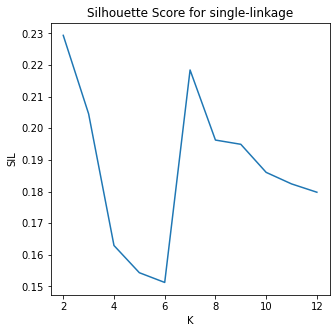

In [137]:
interpret_dendogram('single')

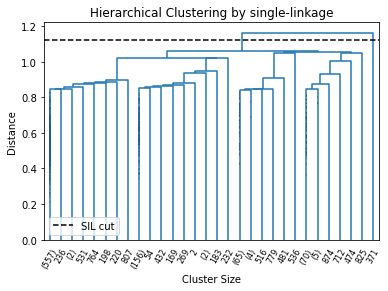

In [138]:
# We plot the dendrogram
cut_distance = 1.12
plot_dendrogram(model_single, cut_distance, "single-linkage", truncate_mode='lastp', p=30, leaf_rotation=60, 
                leaf_font_size = 8, show_contracted=True)

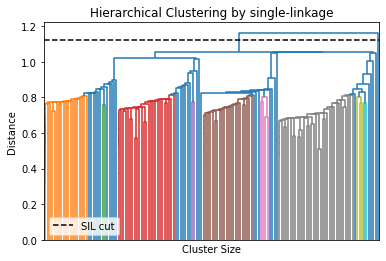

In [139]:
# We plot the dendrogram
cut_distance = 1.12
plot_dendrogram(model_single, cut_distance, "single-linkage", truncate_mode='level', p=30, no_labels=True,
                leaf_rotation=60, leaf_font_size = 8, show_contracted=True)

The single-linkage agglomerative clustering suggests the presence of 2 main cluster, being the result of the merging process of 2 main subclusters, one composed by 882 points and the second by a single point. As we can notice the first cluster is clumped together, probably due to the presence of noisy points that made its subcluster merge.

<h6> The Farthest Point Algorithm: complete-linkage </h6>
It is based on the complete (Max) linkage, measuring the proximity of two clusters by the distance of their fartherst points.

Being more <b>resistant to outliers and noise</b>, the complete-linkage should prove more reliable than the single one. However, one drowback is to <b>break the larger clusters into smaller globular ones</b>.

In [140]:
# We want to compute the entire tree
model_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', 
                                                                         linkage='complete').fit(df_probe)

Cluster numbers:  2
Cluster {0: 728, 1: 155}
Silhouette Score 0.22595970310387847
Cluster numbers:  3
Cluster {0: 155, 1: 565, 2: 163}
Silhouette Score 0.2203540749231785
Cluster numbers:  4
Cluster {0: 87, 1: 565, 2: 163, 3: 68}
Silhouette Score 0.22705407725073745
Cluster numbers:  5
Cluster {0: 565, 1: 83, 2: 163, 3: 68, 4: 4}
Silhouette Score 0.22280125273508
Cluster numbers:  6
Cluster {0: 163, 1: 83, 2: 133, 3: 68, 4: 4, 5: 432}
Silhouette Score 0.13533877332575842
Cluster numbers:  7
Cluster {0: 83, 1: 128, 2: 133, 3: 68, 4: 4, 5: 432, 6: 35}
Silhouette Score 0.10780431017849845
Cluster numbers:  8
Cluster {0: 133, 1: 128, 2: 432, 3: 68, 4: 4, 5: 77, 6: 35, 7: 6}
Silhouette Score 0.10455767085021864
Cluster numbers:  9
Cluster {0: 432, 1: 128, 2: 100, 3: 68, 4: 4, 5: 77, 6: 35, 7: 6, 8: 33}
Silhouette Score 0.09388690922165899
Cluster numbers:  10
Cluster {0: 100, 1: 128, 2: 322, 3: 68, 4: 110, 5: 77, 6: 35, 7: 6, 8: 33, 9: 4}
Silhouette Score 0.0941507714650934
Cluster numbers:

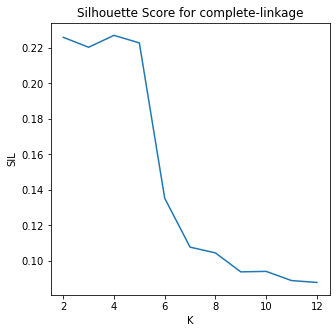

In [141]:
interpret_dendogram('complete')

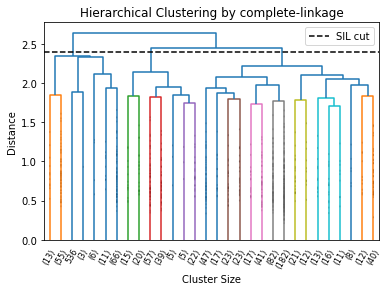

In [142]:
# We plot the dendrogram
cut_distance = 2.40
plot_dendrogram(model_complete, cut_distance, "complete-linkage", truncate_mode='lastp', 
                                                    p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True)

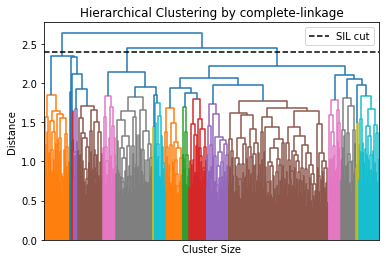

In [143]:
# We plot the dendrogram
cut_distance = 2.40
plot_dendrogram(model_complete, cut_distance, "complete-linkage", truncate_mode='level', p=30, leaf_rotation=60, 
                no_labels=True, leaf_font_size = 8, show_contracted=True)

The comple-linkage agglomerative clustering suggests the presence of 4 main cluster, being the result of the merging process of 4 main subclusters, the first composed by 565 points, the second by 87 points, the thirs by 164 points and the third by 68 points. As we can notice from the dendogram, usually these main clusters are the result of fragmented subcluster merged together (the drawback of comple-linkage is to break big clusters into smaller ones).

<h6> The UPGMA Algorithm: average-linkage </h6>
It stands as a <b>trade-off between the complete and single linkages</b>. The proximity of two clusters is the average of the pairwise proximity between the points of the two clusters.
As the complete linkage, it is <b>less susceptible to noise and outliers</b>, but it also tends to </b>prefer globular clusters</b>.

In [144]:
# We want to compute the entire tree
model_average = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', 
                                        linkage='average').fit(df_probe)

Cluster numbers:  2
Cluster {0: 882, 1: 1}
Silhouette Score 0.21743956506578824
Cluster numbers:  3
Cluster {0: 730, 1: 1, 2: 152}
Silhouette Score 0.20880637166880056
Cluster numbers:  4
Cluster {0: 728, 1: 2, 2: 152, 3: 1}
Silhouette Score 0.15700886174715806
Cluster numbers:  5
Cluster {0: 152, 1: 165, 2: 563, 3: 1, 4: 2}
Silhouette Score 0.18779654654140304
Cluster numbers:  6
Cluster {0: 563, 1: 165, 2: 80, 3: 1, 4: 2, 5: 72}
Silhouette Score 0.20130338634509937
Cluster numbers:  7
Cluster {0: 80, 1: 165, 2: 561, 3: 1, 4: 2, 5: 72, 6: 2}
Silhouette Score 0.17361573124116703
Cluster numbers:  8
Cluster {0: 561, 1: 165, 2: 78, 3: 2, 4: 2, 5: 72, 6: 2, 7: 1}
Silhouette Score 0.1687173970092525
Cluster numbers:  9
Cluster {0: 554, 1: 165, 2: 78, 3: 7, 4: 2, 5: 72, 6: 2, 7: 1, 8: 2}
Silhouette Score 0.15417460171638497
Cluster numbers:  10
Cluster {0: 545, 1: 165, 2: 78, 3: 7, 4: 9, 5: 72, 6: 2, 7: 1, 8: 2, 9: 2}
Silhouette Score 0.14740193879363286
Cluster numbers:  11
Cluster {0: 165

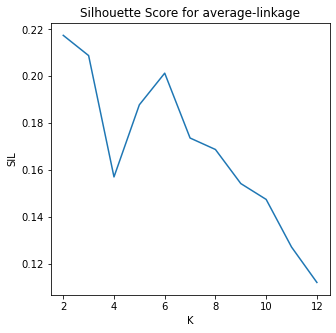

In [145]:
interpret_dendogram('average')

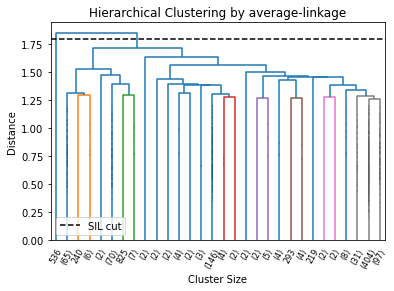

In [146]:
cut_distance = 1.80
plot_dendrogram(model_average, cut_distance, "average-linkage", truncate_mode='lastp',
                p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True)

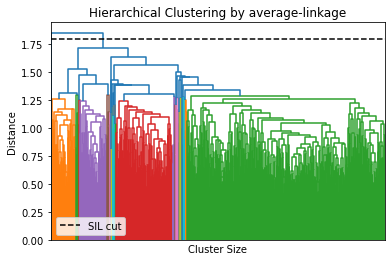

In [147]:
cut_distance = 1.80
plot_dendrogram(model_average, cut_distance, "average-linkage", truncate_mode='level', p=30, 
                leaf_rotation=60, leaf_font_size = 8, no_labels=True, show_contracted=True)

The average-linkage agglomerative clustering suggests the presence of 2 main cluster, being the result of the merging process of 2 main subclusters, one composed by 1 points and the second by 882 points.
Since it is a trade-off between the complete and single linkages, we can again see how it is susceptile to noise, noticing, however, that the subclusters are less clumped together. 

<h6> The Incremental Algorithm: ward-linkage </h6>
It stands as the hierarchical <b>analogue of K-means</b> and, like the former, it is a <b>centroid based approach</b> with a particular interest in the minimization of the SSE values associated with each cluster.

In [148]:
# We want to compute the entire tree
model_ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', 
                                     linkage='ward').fit(df_probe)

Cluster numbers:  2
Cluster {0: 318, 1: 565}
Silhouette Score 0.20633796560597278
Cluster numbers:  3
Cluster {0: 153, 1: 565, 2: 165}
Silhouette Score 0.22265364451439684
Cluster numbers:  4
Cluster {0: 565, 1: 80, 2: 165, 3: 73}
Silhouette Score 0.2338716425461628
Cluster numbers:  5
Cluster {0: 424, 1: 141, 2: 165, 3: 73, 4: 80}
Silhouette Score 0.15529139183895746
Cluster numbers:  6
Cluster {0: 335, 1: 141, 2: 165, 3: 73, 4: 80, 5: 89}
Silhouette Score 0.13573357613833215
Cluster numbers:  7
Cluster {0: 141, 1: 267, 2: 165, 3: 73, 4: 80, 5: 89, 6: 68}
Silhouette Score 0.1265763941053908
Cluster numbers:  8
Cluster {0: 267, 1: 70, 2: 165, 3: 73, 4: 80, 5: 89, 6: 68, 7: 71}
Silhouette Score 0.1262962782823297
Cluster numbers:  9
Cluster {0: 119, 1: 70, 2: 165, 3: 148, 4: 80, 5: 89, 6: 68, 7: 71, 8: 73}
Silhouette Score 0.1109103088425964
Cluster numbers:  10
Cluster {0: 165, 1: 70, 2: 85, 3: 148, 4: 80, 5: 89, 6: 68, 7: 71, 8: 73, 9: 34}
Silhouette Score 0.11076612148794256
Cluster 

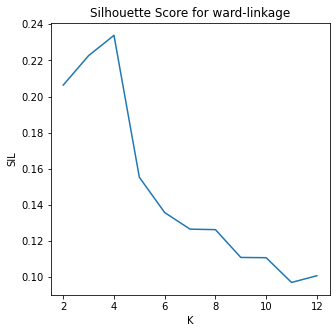

In [149]:
interpret_dendogram('ward')

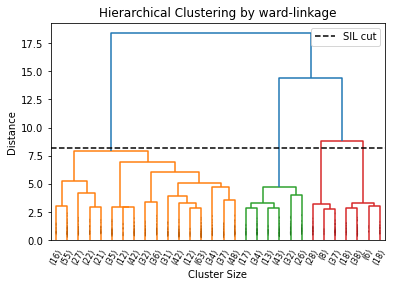

In [150]:
# We plot the dendrogram
cut_distance = 8.2
plot_dendrogram(model_ward, cut_distance, "ward-linkage", truncate_mode='lastp', 
                p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True)

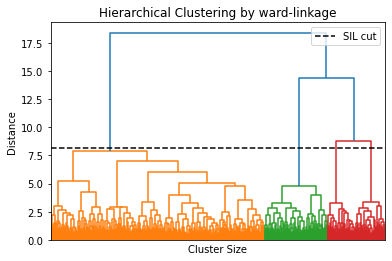

In [151]:
# We plot the dendrogram
cut_distance = 8.2
plot_dendrogram(model_ward, cut_distance, "ward-linkage", truncate_mode='level', p=30, 
                leaf_rotation=60, leaf_font_size = 8, no_labels=True, show_contracted=True)

Since this linkage metric used to merged similar cluster best resembles the K-Means, we expected a correspondence with the best k previously evaluate with the Elbow Method. Here, however, the dendrogram seems to suggest the presence of 4 main clusters, a larger one (565) and three smaller ones (165, 80, 73 points). 

As we can clearly see the larger cluster is divided in two subcluster, which with K-Means weren't generalized, since the smaller candicate for the number of cluster k is set to ?. 

<h6> Best linkage function selection </h6>
In our opinion the best linkage fucntion for our dataset is the <b>ward-linkage</b>. We will be less restrictive with the cut_off level in our analysis, using a k=4 as suggest by the dendogram and a k=5 from graphical inspection. These choises are a validatation and a conforn with K-Means values, too.

<h2>k=4</h2>

In [228]:
k = 4
cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')  
cluster.fit_predict(df_probe)
cluster_label = str(k) + "cluster_label"
df_num[cluster_label] = cluster.labels_  # retrieve points cluster label of appartenence 
df_impunted[cluster_label] = cluster.labels_  # retrieve points cluster label of appartenence 

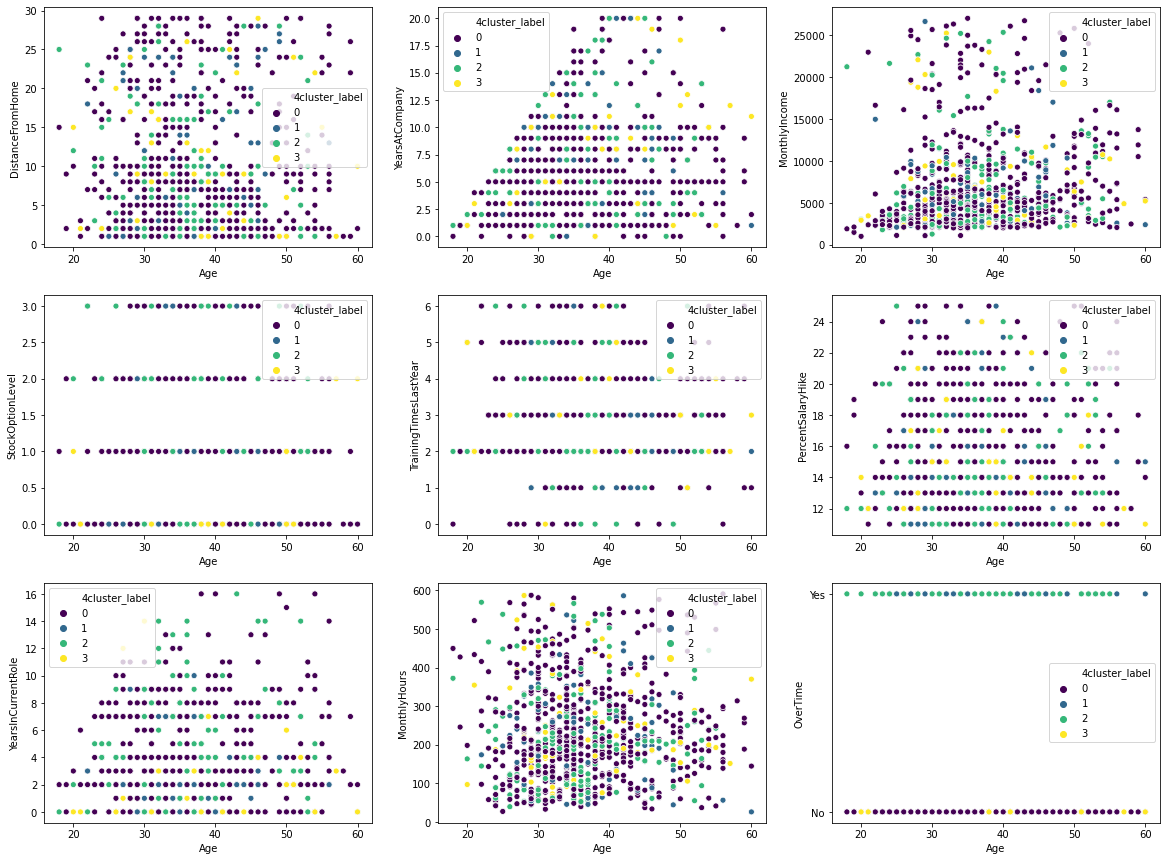

In [229]:
curr_column = "Age"
fig =plt.subplots(figsize=(20, 15))
fig_dims = (3, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns.scatterplot(df_impunted[curr_column], df_impunted['DistanceFromHome'], 
                                                                hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (0, 1))
sns.scatterplot(df_impunted[curr_column], df_impunted['YearsAtCompany'], 
                                                                hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (0, 2))
sns.scatterplot(df_impunted[curr_column], df_impunted['MonthlyIncome'], 
                                                                hue=df_num[cluster_label], palette="viridis")  

ax = plt.subplot2grid(fig_dims, (1, 0))
sns.scatterplot(df_impunted[curr_column], df_impunted['StockOptionLevel'], 
                                                                hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (1, 1))
sns.scatterplot(df_impunted[curr_column], df_impunted['TrainingTimesLastYear'], 
                                                                 hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (1, 2))
sns.scatterplot(df_impunted[curr_column], df_impunted['PercentSalaryHike'], 
                                                                hue=df_num[cluster_label], palette="viridis")  

ax = plt.subplot2grid(fig_dims, (2, 0))
sns.scatterplot(df_impunted[curr_column], df_impunted['YearsInCurrentRole'], 
                                                             hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (2, 1))
sns.scatterplot(df_impunted[curr_column], df_impunted['MonthlyHours'], 
                                                            hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (2, 2))
sns.scatterplot(df_impunted[curr_column], df_impunted['OverTime'], 
                                                            hue=df_num[cluster_label], palette="viridis")  

plt.show()

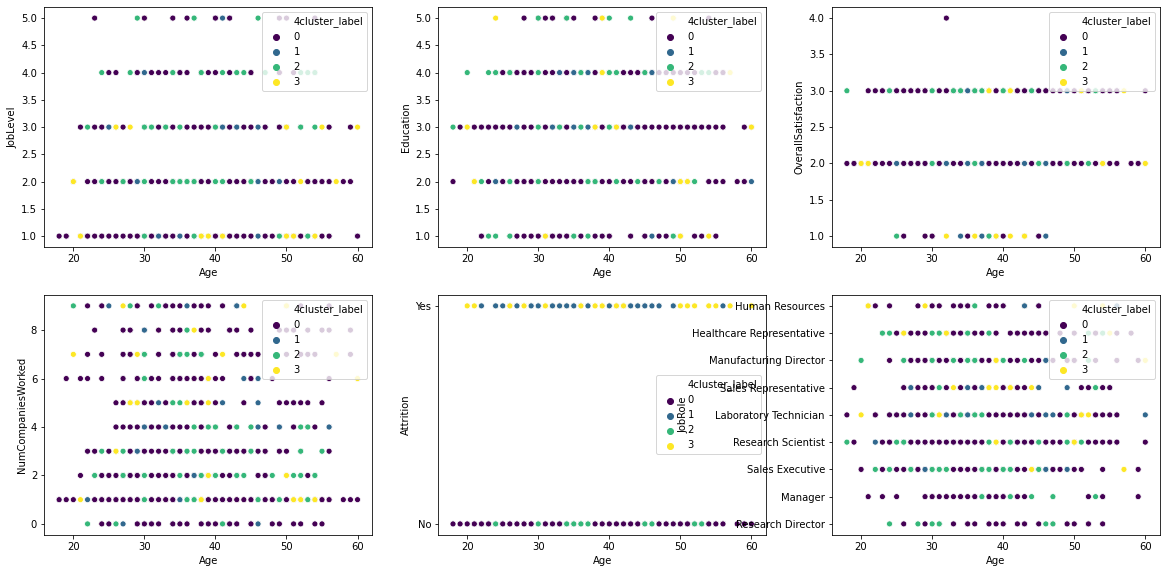

In [230]:
curr_column = "Age"
fig =plt.subplots(figsize=(20, 15))
fig_dims = (3, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns.scatterplot(df_impunted[curr_column], df_impunted['JobLevel'], 
                                                            hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (0, 1))
sns.scatterplot(df_impunted[curr_column], df_impunted['Education'], 
                                                            hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (0, 2))
sns.scatterplot(df_impunted[curr_column], df_impunted['OverallSatisfaction'], 
                                                            hue=df_num[cluster_label], palette="viridis")  

ax = plt.subplot2grid(fig_dims, (1, 0))
sns.scatterplot(df_impunted[curr_column], df_impunted['NumCompaniesWorked'], 
                                                            hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (1, 1))
sns.scatterplot(df_impunted[curr_column], df_impunted['Attrition'], 
                                                            hue=df_num[cluster_label], palette="viridis") 

ax = plt.subplot2grid(fig_dims, (1, 2))
sns.scatterplot(df_impunted[curr_column], df_impunted['JobRole'], 
                                                            hue=df_num[cluster_label], palette="viridis") 

plt.show()

In [231]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

def plot_3d_scatterplot(df, x, y, y2, secondplot_flag):
    # axes instance
    fig = plt.figure(figsize=(20, 10))
    fig_dims = (1, 2)

    # plot
    ax = plt.subplot2grid(fig_dims, (0, 0), projection='3d')
    sc = ax.scatter(df[x].astype(int), df[y].astype(int), df_num["Attrition"], c=df_num[cluster_label], marker='o')
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel("Attrition")
    # legend
    plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2, title="Cluster")
    
    if secondplot_flag:
        # plot
        ax = plt.subplot2grid(fig_dims, (0, 1), projection='3d')
        try:
            sc = ax.scatter(df[x].astype(int), df[y2].astype(int), df_num["Attrition"], c=df_num[cluster_label], marker='o')
        except ValueError:
            sc = ax.scatter(df[x].astype(int), df_num[y2], df_num["Attrition"], c=df_num[cluster_label], marker='o')
        ax.set_xlabel(x)
        ax.set_ylabel(y2)
        ax.set_zlabel("Attrition")
        # legend
        plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2, title="Cluster")
        
    
    plt.show()

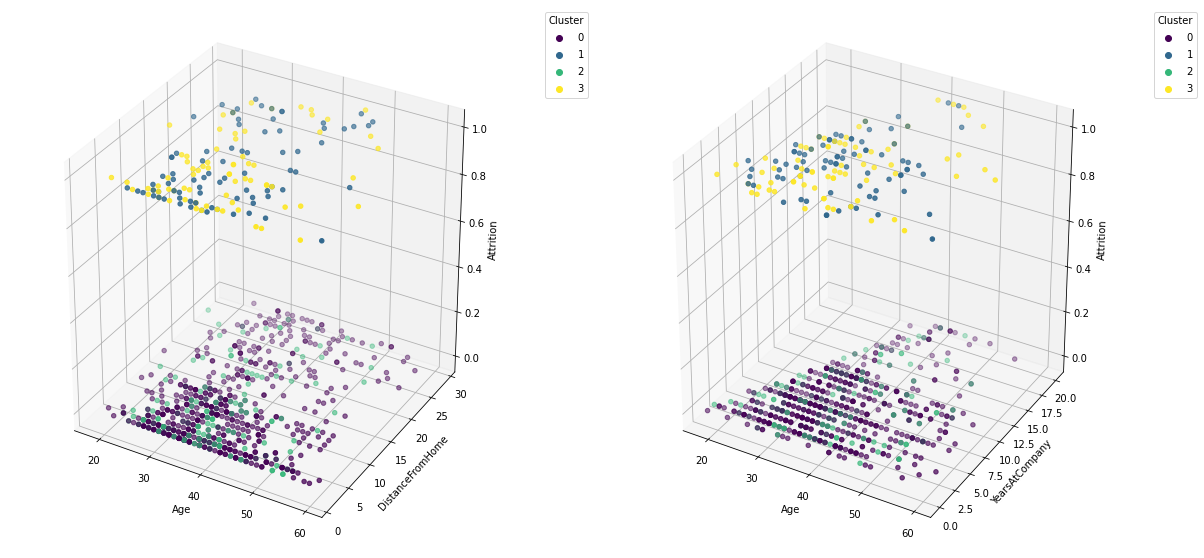

In [232]:
plot_3d_scatterplot(df_impunted, 'Age', 'DistanceFromHome', 'YearsAtCompany', True)

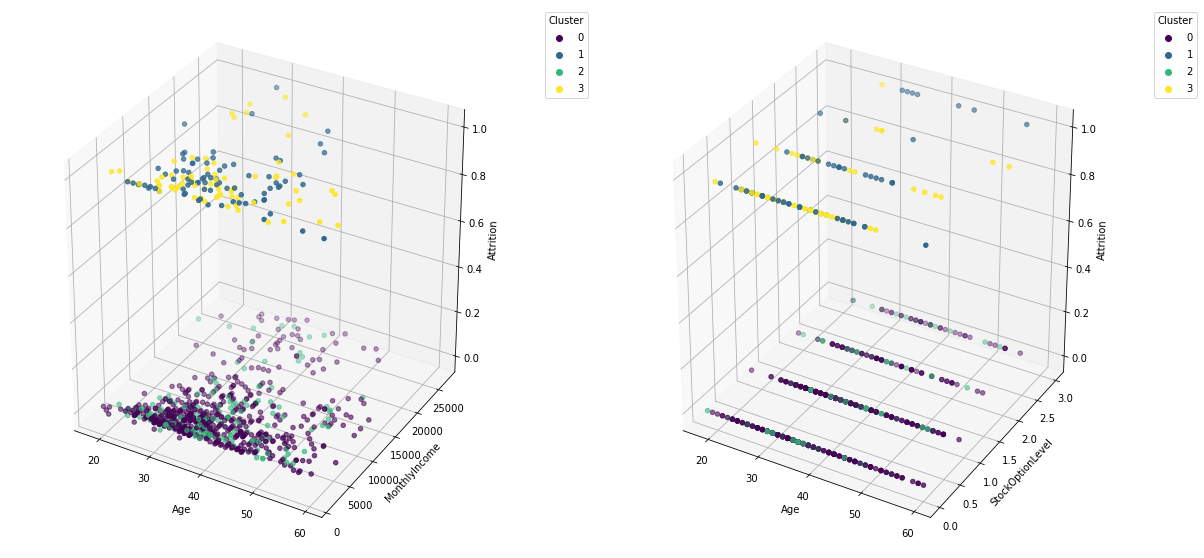

In [233]:
plot_3d_scatterplot(df_impunted, 'Age', 'MonthlyIncome', 'StockOptionLevel', True)

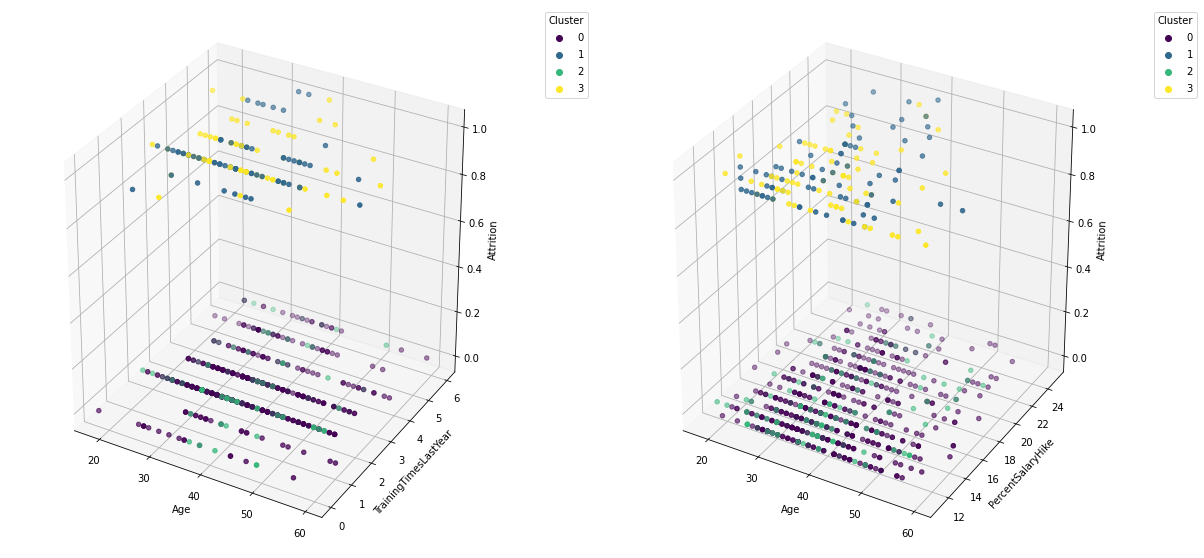

In [234]:
plot_3d_scatterplot(df_impunted, 'Age', 'TrainingTimesLastYear', 'PercentSalaryHike', True)

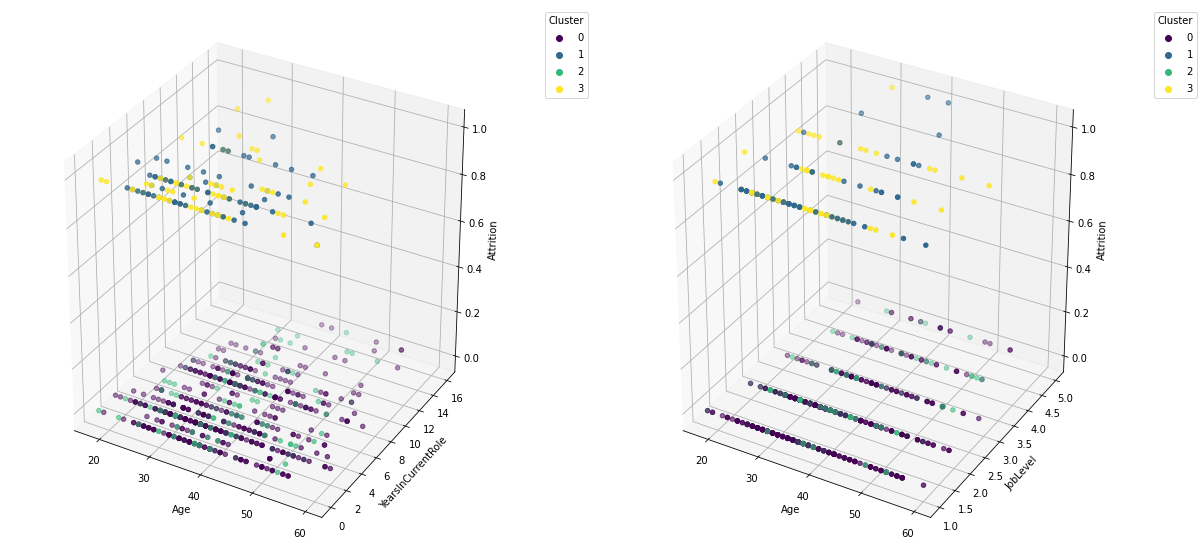

In [235]:
plot_3d_scatterplot(df_impunted, 'Age', 'YearsInCurrentRole', 'JobLevel', True)

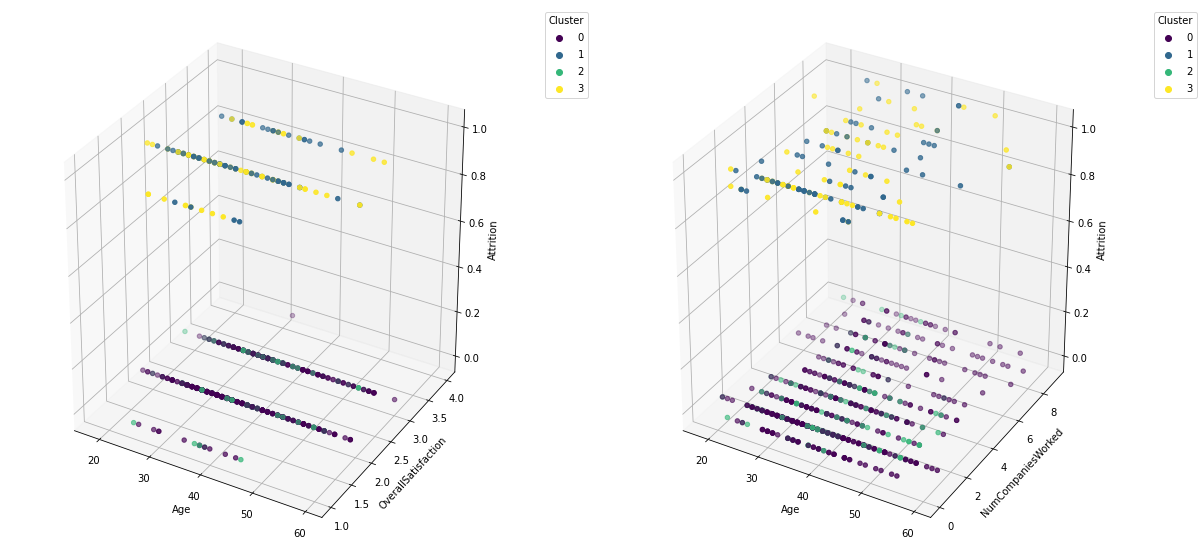

In [236]:
plot_3d_scatterplot(df_impunted, 'Age', 'OverallSatisfaction', 'NumCompaniesWorked', True)

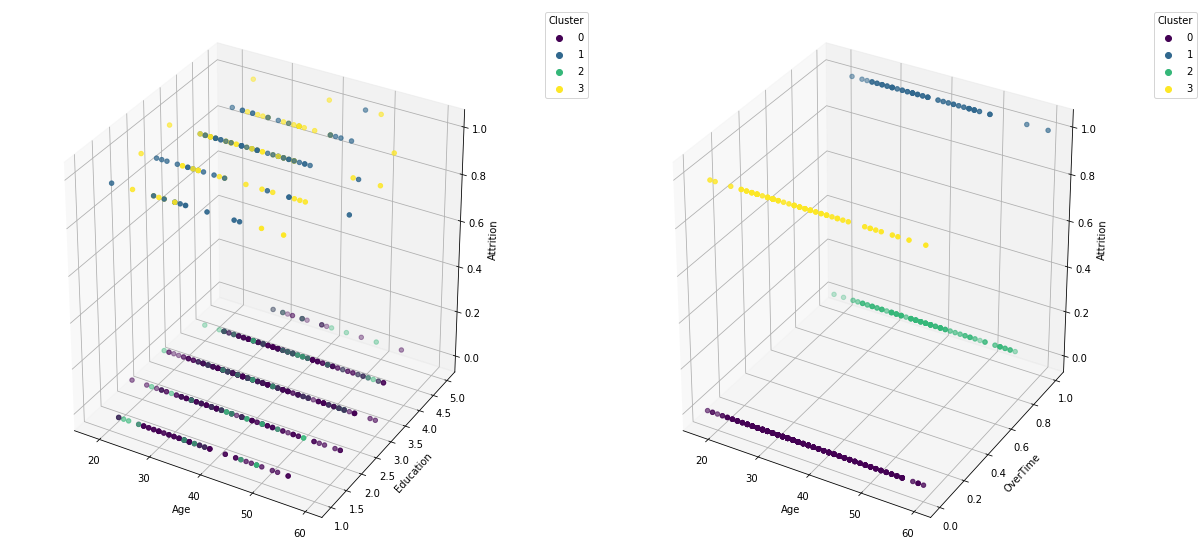

In [237]:
plot_3d_scatterplot(df_impunted, 'Age', 'Education', 'OverTime', True)

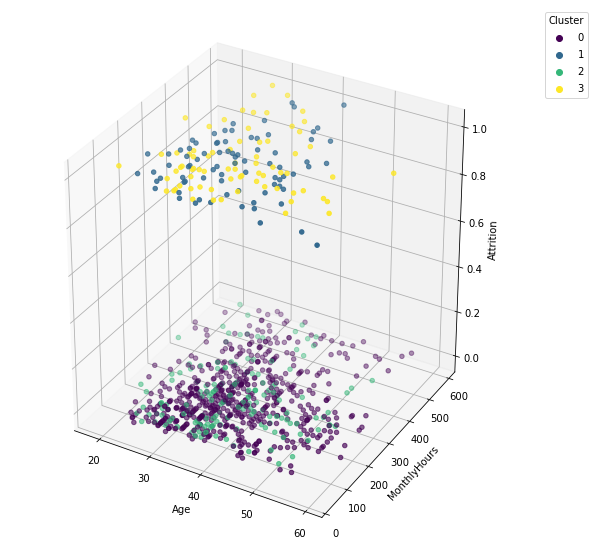

In [238]:
plot_3d_scatterplot(df_impunted, 'Age', 'MonthlyHours', "", False)

In [239]:
def draw_stacked_bar(column_name1, column_name2, df1, df2, annotate_flag, ax, xticks_rotation, loc, cmap, title):
    
    patch_handles = []
    frames = [df1[[column_name1]], df2[[column_name2]]]
    concat_df = pd.concat(frames, axis=1)  # merge Dataframes across columns
    
    # get a frequency table of  column_name1 and column_name2
    pclass_xt = pd.crosstab(concat_df[column_name1], concat_df[column_name2]).dropna()
    if cmap != "":
        patch_handles.append(pclass_xt.plot(kind="bar", stacked=True, ax=ax, cmap=cmap))
    else:
        patch_handles.append(pclass_xt.plot(kind="bar", stacked=True, ax=ax))
    plt.xlabel(column_name1)
    plt.ylabel('count')
    plt.xticks(rotation=xticks_rotation)
    
    # get sub-DataFrame made out by column_name1 and column_name2 concatenation, without NaN values
    curr_df = concat_df[[column_name1, column_name2]].dropna()
    unique_values = sorted(curr_df[column_name1].unique())  # alphabetical order
    tmp_xticks_tot_elements = {}

    # search all of the bar segments and annotate
    for rec in ax.patches:
        height = rec.get_height()
        x = rec.get_x() + rec.get_width() / 2
        y = rec.get_y() + height / 2
        current_value = unique_values[int(x)]  # index with xticks unique column_name1's values
        tot_current_value = curr_df[curr_df[column_name1] == current_value][column_name1].shape[0] 
        percentage =  "{:.0f}%".format(height /tot_current_value*100)

        try:
            tmp_count = tmp_xticks_tot_elements[str(x)]
            tmp_count += height
            tmp_xticks_tot_elements[str(x)] = tmp_count
        except KeyError:
             tmp_xticks_tot_elements[str(x)] = height

        if annotate_flag:
            ax.text(x, y, percentage, ha='center', va='bottom')

    # put total number of elements on top of each bar
    for x, tot_x in tmp_xticks_tot_elements.items():
        ax.text(float(x), tot_x, str(int(tot_x)), ha='center', va='bottom')
        
    # adjust legend's position
    if loc != "":
        plt.legend(title=column_name2, loc=loc)
        
    plt.title(title)

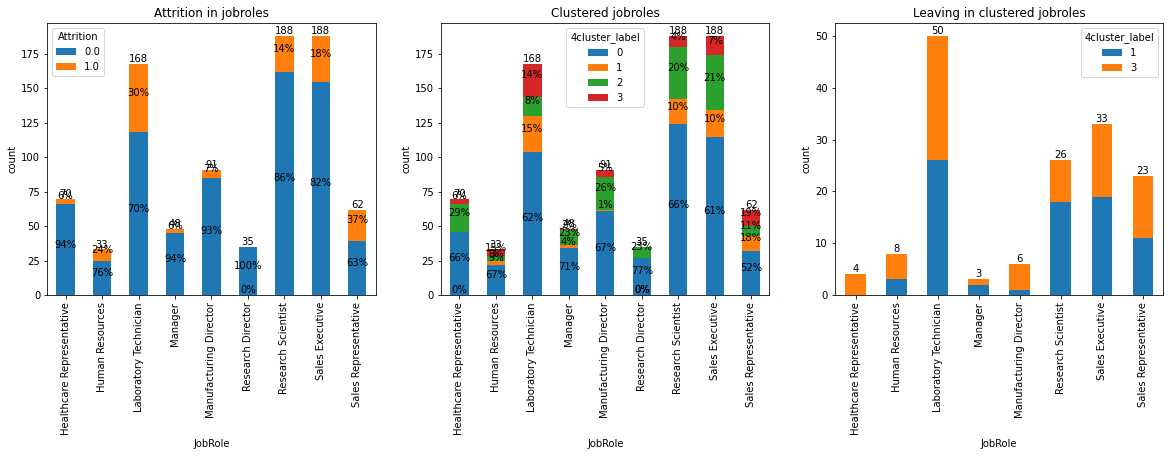

In [240]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "Attrition", df_impunted, df_num, True, ax, 90, "", "", "Attrition in jobroles")
ax = plt.subplot2grid(fig_dims, (0, 1))
draw_stacked_bar(curr_column, cluster_label, df_impunted,  df_num, True, ax, 90, "", "", "Clustered jobroles")
ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, cluster_label, df_impunted[df_impunted["Attrition"] == "Yes"], 
                 df_num[df_num["Attrition"] == 1], False, ax, 90, "", "", "Leaving in clustered jobroles")

<h6> Cluster 1 insight </h6>

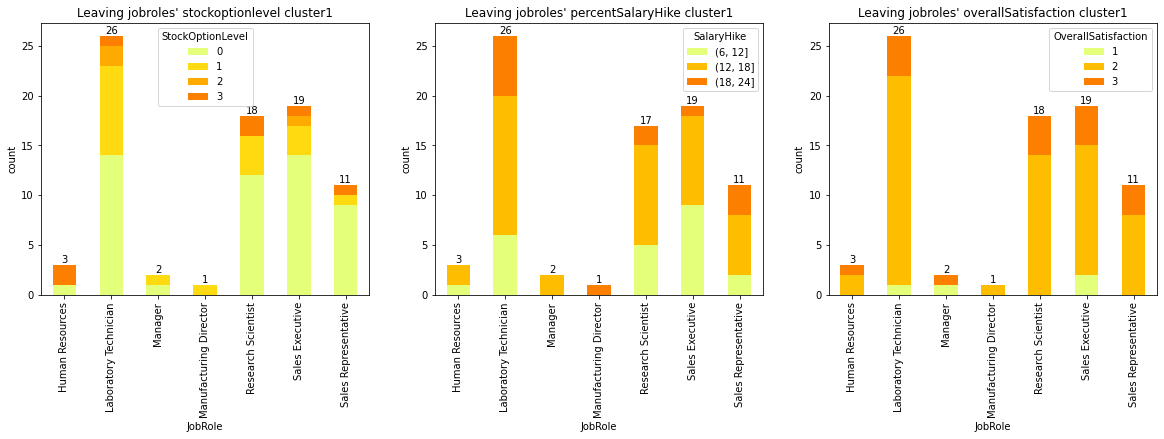

In [241]:
curr_column = "JobRole"
curr_cluster = 1
curr_cmap = "Wistia"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "StockOptionLevel", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"]=="Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' stockoptionlevel cluster" + str(curr_cluster))
 
ax = plt.subplot2grid(fig_dims, (0, 1))
df_hike = df_impunted.copy()
df_hike["SalaryHike"] = pd.cut(x=df_impunted["PercentSalaryHike"], bins=[6, 12, 18, 24])
draw_stacked_bar(curr_column, "SalaryHike", 
                 df_impunted[(df_impunted["Attrition"]=="Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_hike[(df_hike["Attrition"]=="Yes") & (df_hike[cluster_label]==curr_cluster)], 
                 False, ax, 90, "",curr_cmap, "Leaving jobroles' percentSalaryHike cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "OverallSatisfaction", 
                 df_impunted[(df_impunted["Attrition"]=="Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' overallSatisfaction cluster" + str(curr_cluster))

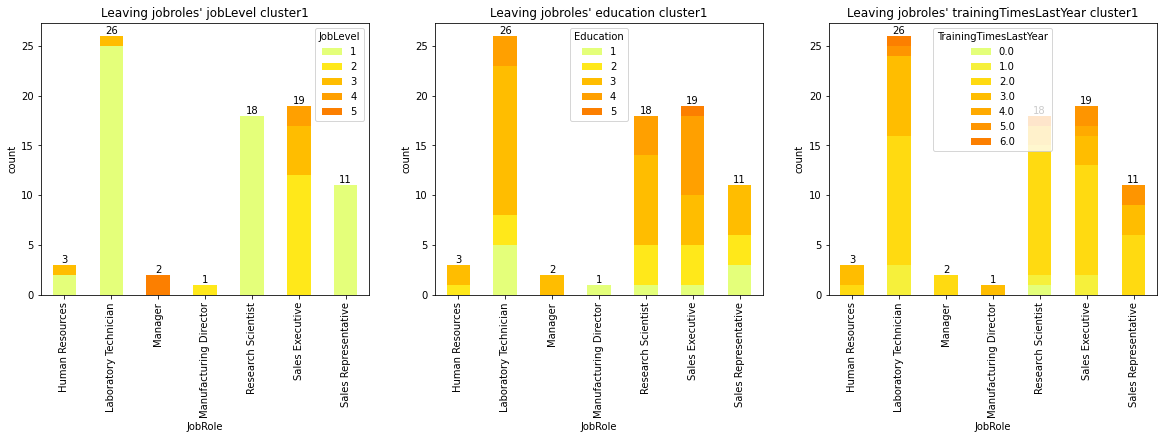

In [242]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "JobLevel", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)],
                False, ax, 90, "", curr_cmap, "Leaving jobroles' jobLevel cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 1))
draw_stacked_bar(curr_column, "Education", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                False, ax, 90, "", curr_cmap, "Leaving jobroles' education cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "TrainingTimesLastYear", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
    False, ax, 90, "upper center", curr_cmap, "Leaving jobroles' trainingTimesLastYear cluster" + str(curr_cluster))

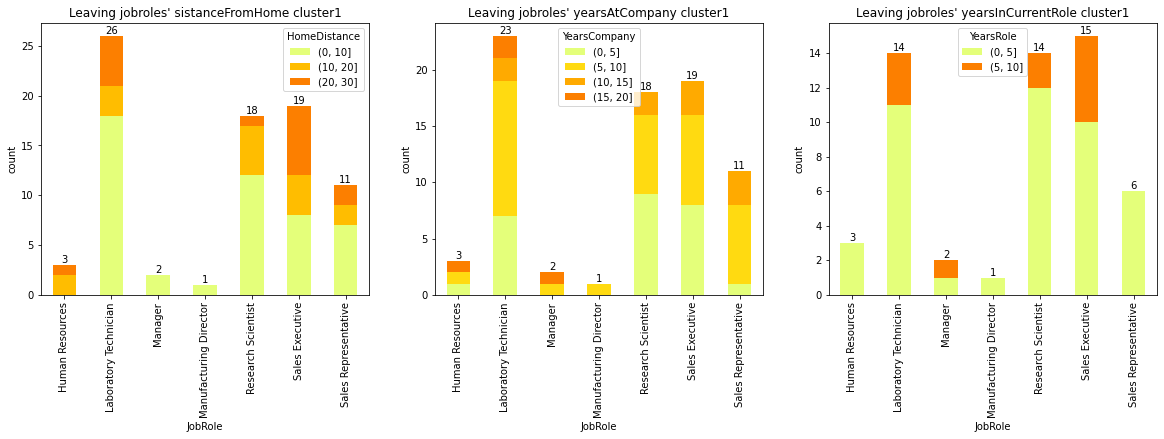

In [243]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
df_dist = df_impunted.copy()
df_dist["HomeDistance"] = pd.cut(x=df_impunted["DistanceFromHome"], bins=[0, 10, 20, 30])
draw_stacked_bar(curr_column, "HomeDistance", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_dist[(df_dist["Attrition"] == "Yes") & (df_dist[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' sistanceFromHome cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 1))
df_yc = df_impunted.copy()
df_yc["YearsCompany"] = pd.cut(x=df_impunted["YearsAtCompany"], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40])
draw_stacked_bar(curr_column, "YearsCompany", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_yc[(df_yc["Attrition"] == "Yes") & (df_yc[cluster_label]==curr_cluster)], 
         False, ax, 90, "upper center", curr_cmap, "Leaving jobroles' yearsAtCompany cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 2))
df_yr = df_impunted.copy()
df_yr["YearsRole"] = pd.cut(x=df_impunted["YearsInCurrentRole"], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40])
draw_stacked_bar(curr_column, "YearsRole", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_yr[(df_yr["Attrition"] == "Yes") & (df_yr[cluster_label]==curr_cluster)], 
    False, ax, 90, "upper center", curr_cmap, "Leaving jobroles' yearsInCurrentRole cluster" + str(curr_cluster))

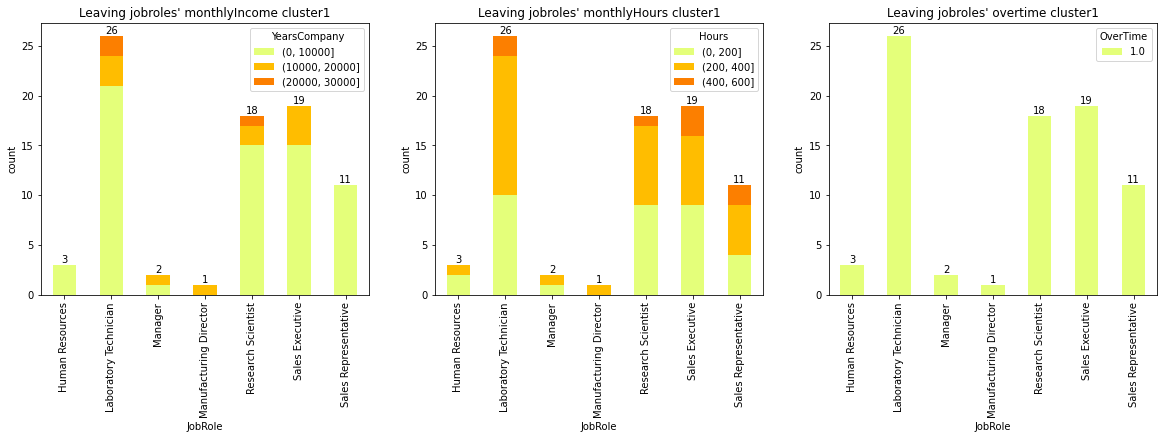

In [244]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
df_income = df_impunted.copy()
df_income["YearsCompany"] = pd.cut(x=df_impunted["MonthlyIncome"], bins=[0, 10000, 20000, 30000])
draw_stacked_bar(curr_column, "YearsCompany", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_income[(df_income["Attrition"] == "Yes") & (df_income[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' monthlyIncome cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 1))
df_h = df_impunted.copy()
df_h["Hours"] = pd.cut(x=df_impunted["MonthlyHours"], bins=[0, 200, 400, 600, 800, 1000])
draw_stacked_bar(curr_column, "Hours",
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_h[(df_h["Attrition"] == "Yes") & (df_h[cluster_label]==curr_cluster)],
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' monthlyHours cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "OverTime", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_num[(df_num["Attrition"] == 1) & (df_num[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' overtime cluster" + str(curr_cluster))

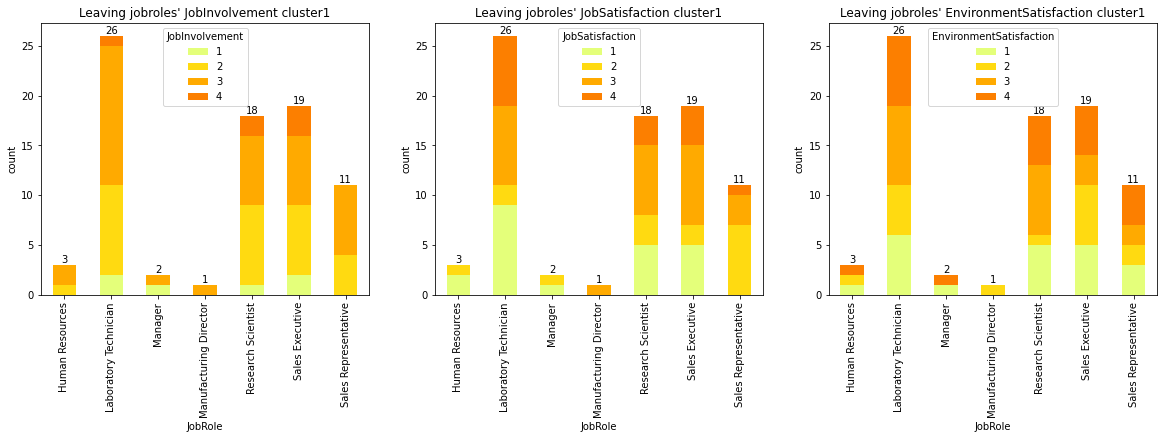

In [245]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "JobInvolvement", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap,
                                                 "Leaving jobroles' JobInvolvement cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 1))
draw_stacked_bar(curr_column, "JobSatisfaction", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)],
                 False, ax, 90, "", curr_cmap,
                                            "Leaving jobroles' JobSatisfaction cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "EnvironmentSatisfaction", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "upper center", curr_cmap,
                                         "Leaving jobroles' EnvironmentSatisfaction cluster" + str(curr_cluster))

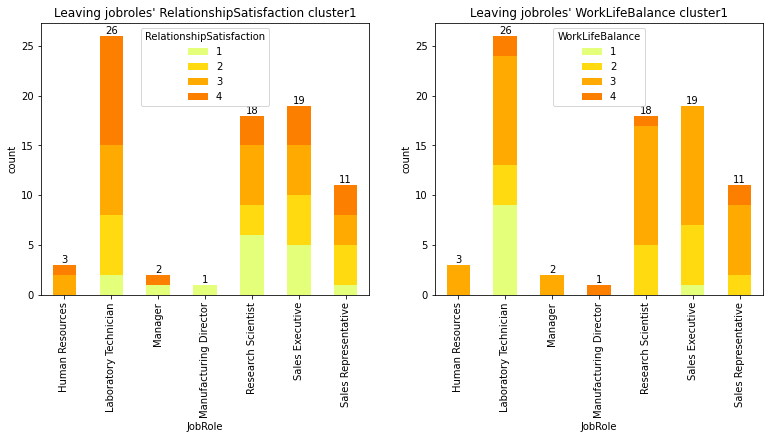

In [246]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "RelationshipSatisfaction", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap,
                                "Leaving jobroles' RelationshipSatisfaction cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 1))
draw_stacked_bar(curr_column, "WorkLifeBalance", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)],
                 False, ax, 90, "", curr_cmap,
                                         "Leaving jobroles' WorkLifeBalance cluster" + str(curr_cluster))

<h6> Cluster 3 insight </h6>

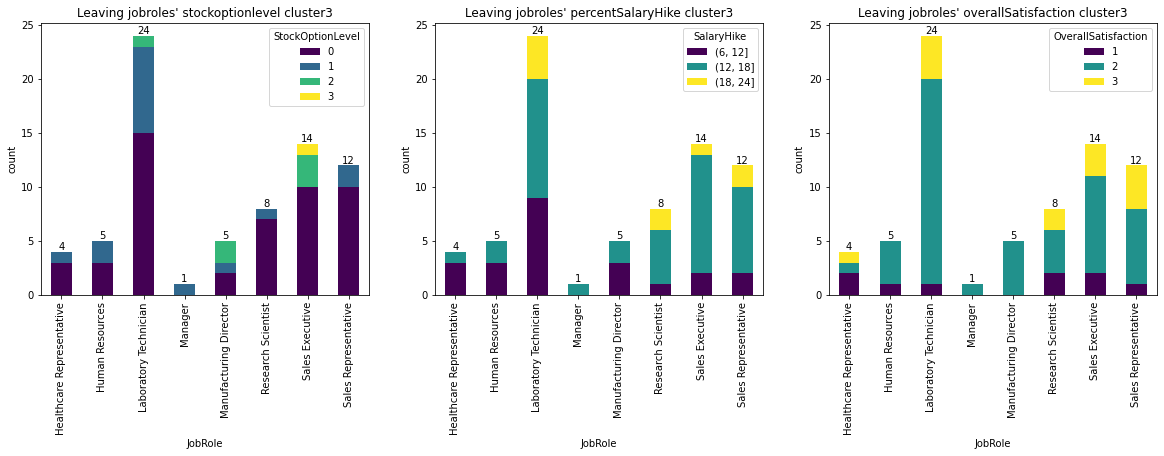

In [247]:
curr_column = "JobRole"
curr_cluster = 3
curr_cmap = "viridis"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "StockOptionLevel", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"]=="Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' stockoptionlevel cluster" + str(curr_cluster))
 
ax = plt.subplot2grid(fig_dims, (0, 1))
df_hike = df_impunted.copy()
df_hike["SalaryHike"] = pd.cut(x=df_impunted["PercentSalaryHike"], bins=[6, 12, 18, 24])
draw_stacked_bar(curr_column, "SalaryHike", 
                 df_impunted[(df_impunted["Attrition"]=="Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_hike[(df_hike["Attrition"]=="Yes") & (df_hike[cluster_label]==curr_cluster)], 
                 False, ax, 90, "",curr_cmap, "Leaving jobroles' percentSalaryHike cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "OverallSatisfaction", 
                 df_impunted[(df_impunted["Attrition"]=="Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' overallSatisfaction cluster" + str(curr_cluster))

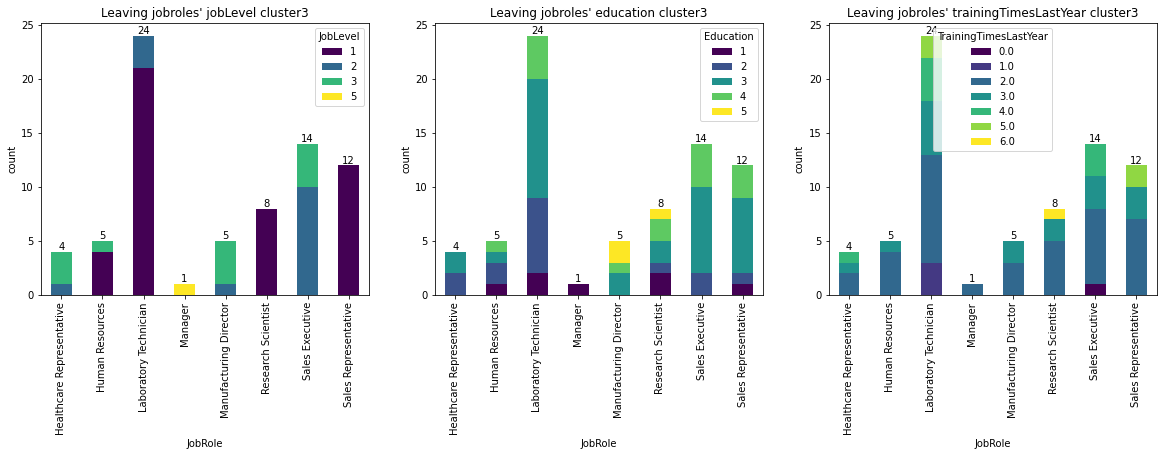

In [248]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "JobLevel", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)],
                False, ax, 90, "", curr_cmap, "Leaving jobroles' jobLevel cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 1))
draw_stacked_bar(curr_column, "Education", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                False, ax, 90, "", curr_cmap, "Leaving jobroles' education cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "TrainingTimesLastYear", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
    False, ax, 90, "upper center", curr_cmap, "Leaving jobroles' trainingTimesLastYear cluster" + str(curr_cluster))

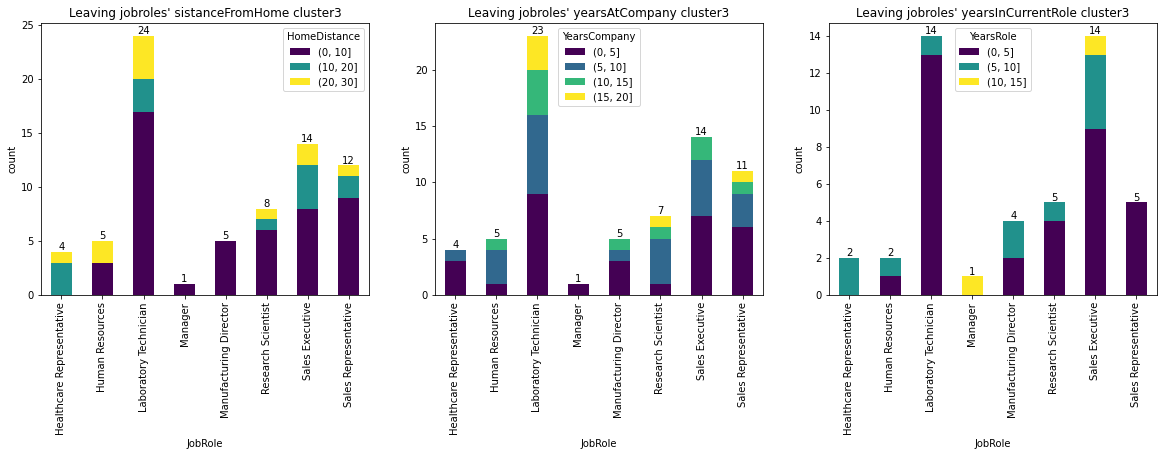

In [249]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
df_dist = df_impunted.copy()
df_dist["HomeDistance"] = pd.cut(x=df_impunted["DistanceFromHome"], bins=[0, 10, 20, 30])
draw_stacked_bar(curr_column, "HomeDistance", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_dist[(df_dist["Attrition"] == "Yes") & (df_dist[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' sistanceFromHome cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 1))
df_yc = df_impunted.copy()
df_yc["YearsCompany"] = pd.cut(x=df_impunted["YearsAtCompany"], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40])
draw_stacked_bar(curr_column, "YearsCompany", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_yc[(df_yc["Attrition"] == "Yes") & (df_yc[cluster_label]==curr_cluster)], 
         False, ax, 90, "upper center", curr_cmap, "Leaving jobroles' yearsAtCompany cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 2))
df_yr = df_impunted.copy()
df_yr["YearsRole"] = pd.cut(x=df_impunted["YearsInCurrentRole"], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40])
draw_stacked_bar(curr_column, "YearsRole", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_yr[(df_yr["Attrition"] == "Yes") & (df_yr[cluster_label]==curr_cluster)], 
    False, ax, 90, "upper center", curr_cmap, "Leaving jobroles' yearsInCurrentRole cluster" + str(curr_cluster))

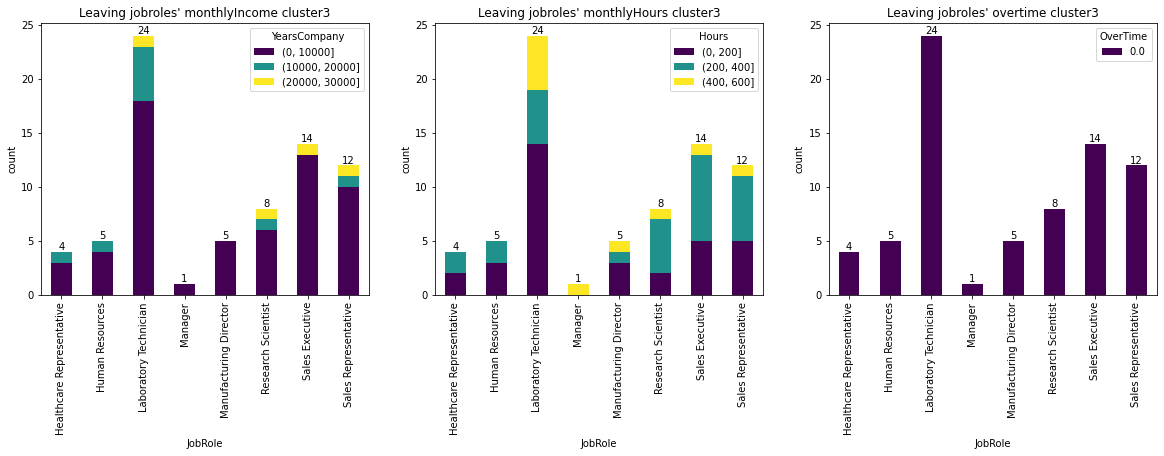

In [250]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
df_income = df_impunted.copy()
df_income["YearsCompany"] = pd.cut(x=df_impunted["MonthlyIncome"], bins=[0, 10000, 20000, 30000])
draw_stacked_bar(curr_column, "YearsCompany", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_income[(df_income["Attrition"] == "Yes") & (df_income[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' monthlyIncome cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 1))
df_h = df_impunted.copy()
df_h["Hours"] = pd.cut(x=df_impunted["MonthlyHours"], bins=[0, 200, 400, 600, 800, 1000])
draw_stacked_bar(curr_column, "Hours",
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_h[(df_h["Attrition"] == "Yes") & (df_h[cluster_label]==curr_cluster)],
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' monthlyHours cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "OverTime", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_num[(df_num["Attrition"] == 1) & (df_num[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' overtime cluster" + str(curr_cluster))

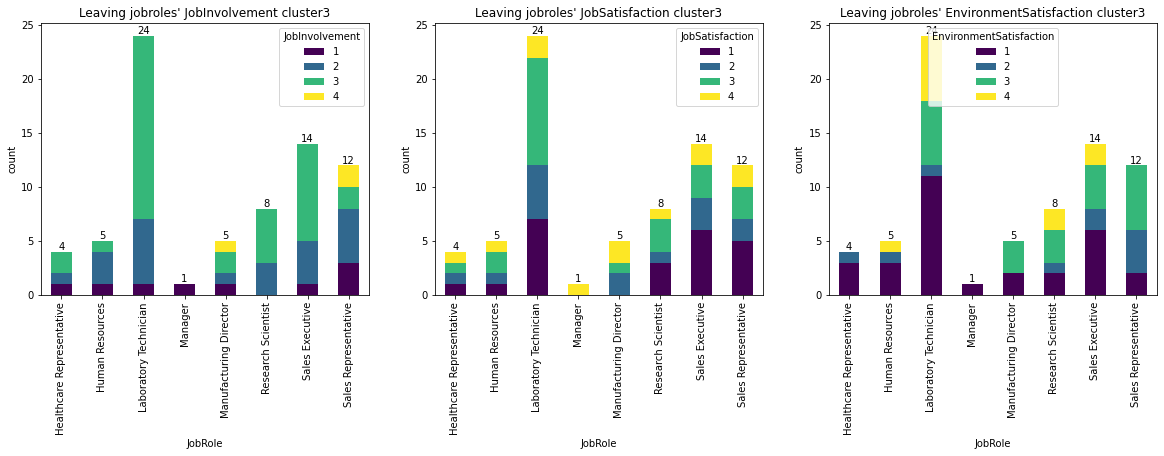

In [251]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "JobInvolvement", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap,
                                                 "Leaving jobroles' JobInvolvement cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 1))
draw_stacked_bar(curr_column, "JobSatisfaction", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)],
                 False, ax, 90, "", curr_cmap,
                                            "Leaving jobroles' JobSatisfaction cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "EnvironmentSatisfaction", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "upper center", curr_cmap,
                                         "Leaving jobroles' EnvironmentSatisfaction cluster" + str(curr_cluster))

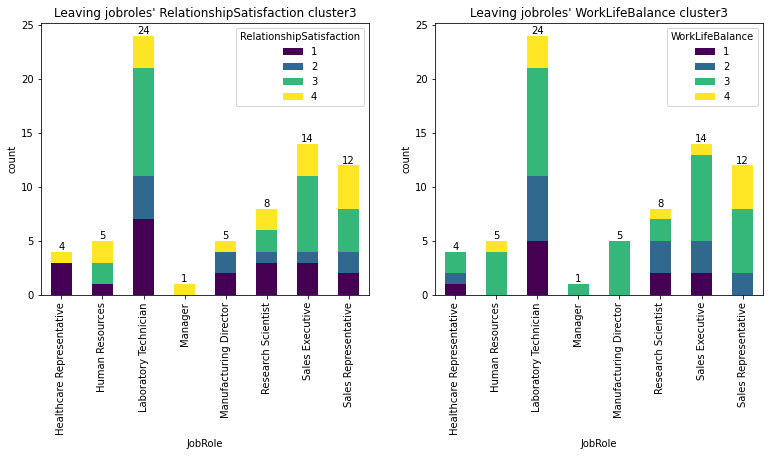

In [252]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "RelationshipSatisfaction", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap,
                                "Leaving jobroles' RelationshipSatisfaction cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 1))
draw_stacked_bar(curr_column, "WorkLifeBalance", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)],
                 False, ax, 90, "", curr_cmap,
                                         "Leaving jobroles' WorkLifeBalance cluster" + str(curr_cluster))

<h2>k=5</h2>

In [253]:
k = 5
cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')  
cluster.fit_predict(df_probe)
cluster_label = str(k) + "cluster_label"
df_num[cluster_label] = cluster.labels_  # retrieve points cluster label of appartenence 
df_impunted[cluster_label] = cluster.labels_  # retrieve points cluster label of appartenence 

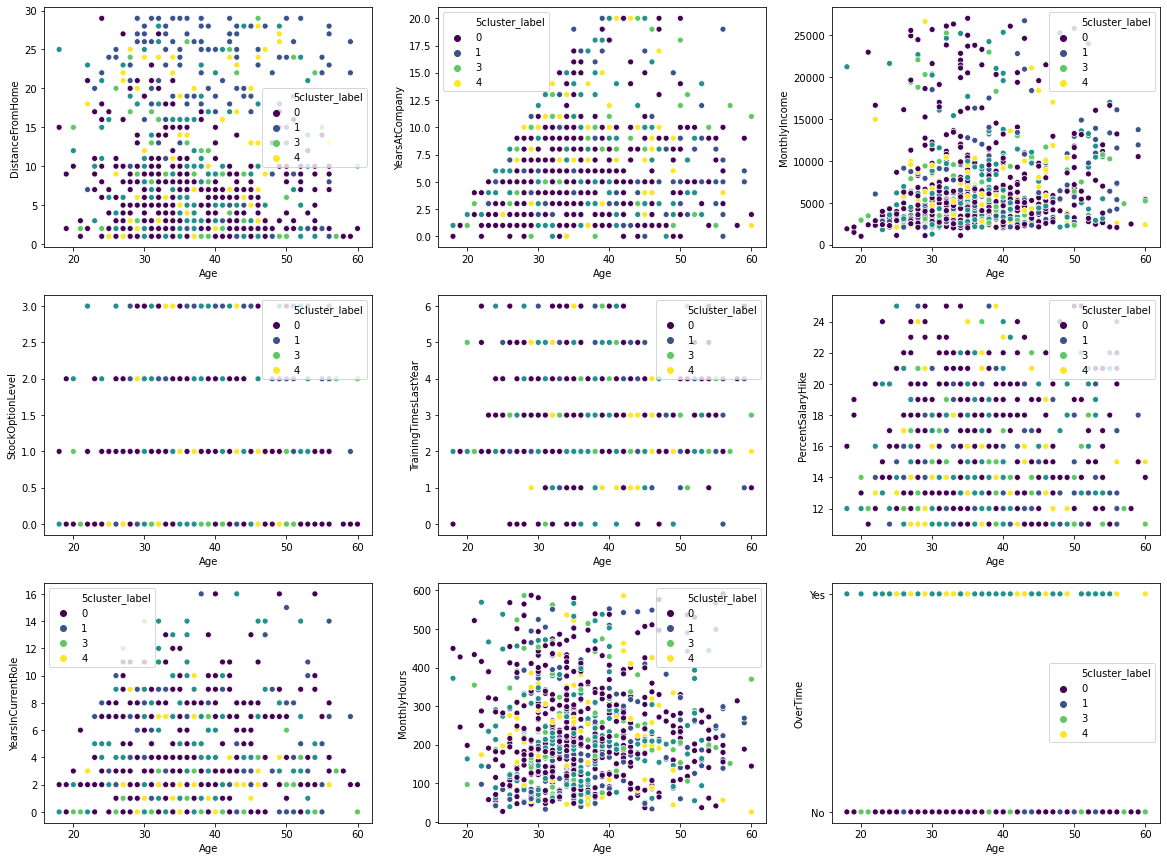

In [254]:
curr_column = "Age"
fig =plt.subplots(figsize=(20, 15))
fig_dims = (3, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns.scatterplot(df_impunted[curr_column], df_impunted['DistanceFromHome'], 
                                                                hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (0, 1))
sns.scatterplot(df_impunted[curr_column], df_impunted['YearsAtCompany'], 
                                                                hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (0, 2))
sns.scatterplot(df_impunted[curr_column], df_impunted['MonthlyIncome'], 
                                                                hue=df_num[cluster_label], palette="viridis")  

ax = plt.subplot2grid(fig_dims, (1, 0))
sns.scatterplot(df_impunted[curr_column], df_impunted['StockOptionLevel'], 
                                                                hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (1, 1))
sns.scatterplot(df_impunted[curr_column], df_impunted['TrainingTimesLastYear'], 
                                                                 hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (1, 2))
sns.scatterplot(df_impunted[curr_column], df_impunted['PercentSalaryHike'], 
                                                                hue=df_num[cluster_label], palette="viridis")  

ax = plt.subplot2grid(fig_dims, (2, 0))
sns.scatterplot(df_impunted[curr_column], df_impunted['YearsInCurrentRole'], 
                                                             hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (2, 1))
sns.scatterplot(df_impunted[curr_column], df_impunted['MonthlyHours'], 
                                                            hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (2, 2))
sns.scatterplot(df_impunted[curr_column], df_impunted['OverTime'], 
                                                            hue=df_num[cluster_label], palette="viridis")  

plt.show()

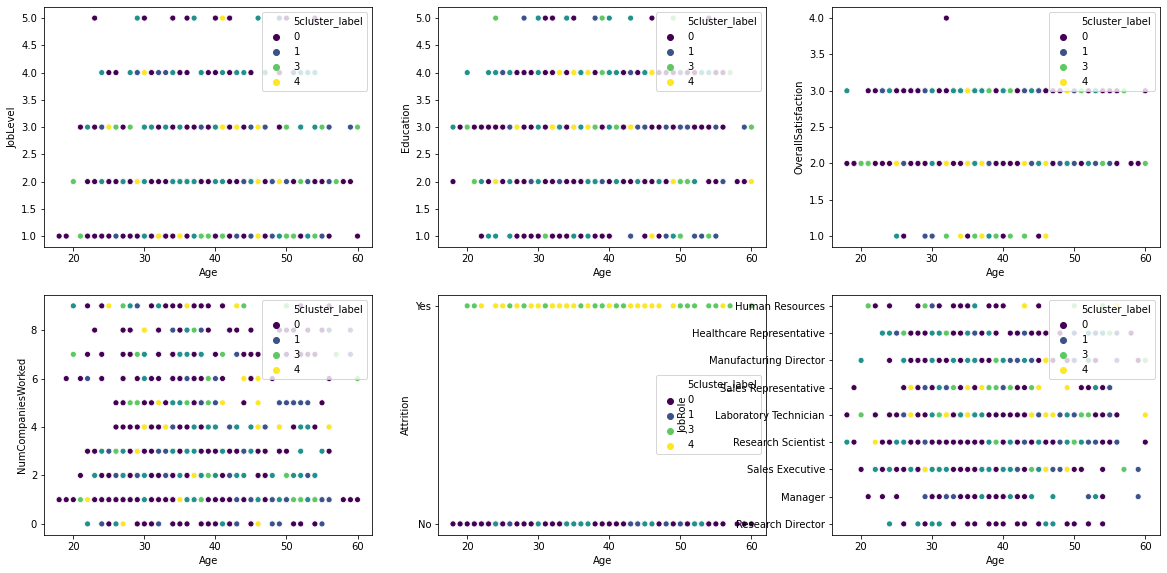

In [255]:
curr_column = "Age"
fig =plt.subplots(figsize=(20, 15))
fig_dims = (3, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns.scatterplot(df_impunted[curr_column], df_impunted['JobLevel'], 
                                                            hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (0, 1))
sns.scatterplot(df_impunted[curr_column], df_impunted['Education'], 
                                                            hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (0, 2))
sns.scatterplot(df_impunted[curr_column], df_impunted['OverallSatisfaction'], 
                                                            hue=df_num[cluster_label], palette="viridis")  

ax = plt.subplot2grid(fig_dims, (1, 0))
sns.scatterplot(df_impunted[curr_column], df_impunted['NumCompaniesWorked'], 
                                                            hue=df_num[cluster_label], palette="viridis") 
ax = plt.subplot2grid(fig_dims, (1, 1))
sns.scatterplot(df_impunted[curr_column], df_impunted['Attrition'], 
                                                            hue=df_num[cluster_label], palette="viridis") 

ax = plt.subplot2grid(fig_dims, (1, 2))
sns.scatterplot(df_impunted[curr_column], df_impunted['JobRole'], 
                                                            hue=df_num[cluster_label], palette="viridis") 

plt.show()

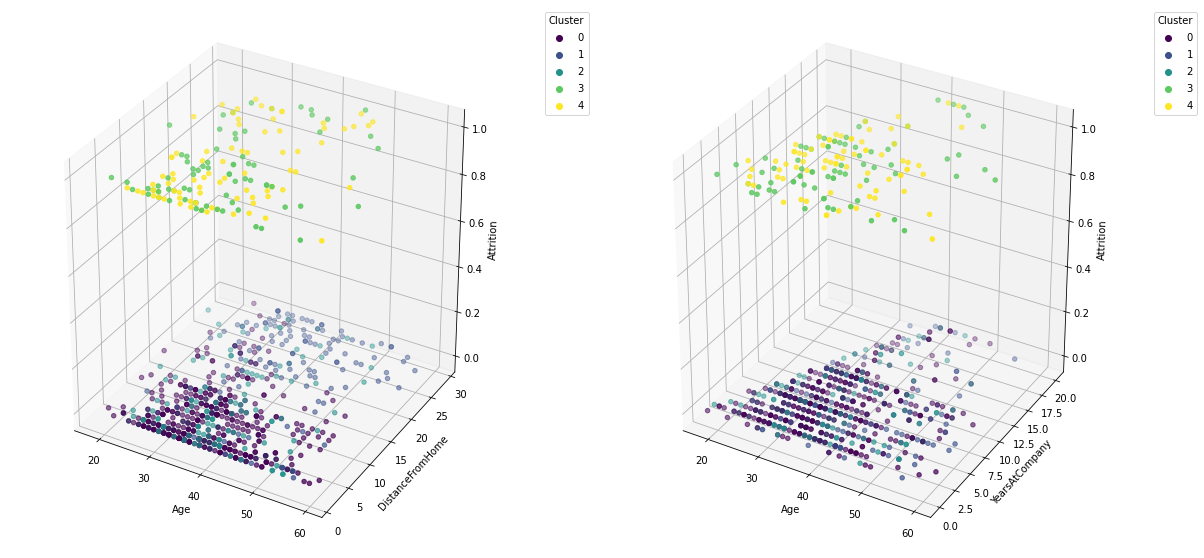

In [256]:
plot_3d_scatterplot(df_impunted, 'Age', 'DistanceFromHome', 'YearsAtCompany', True)

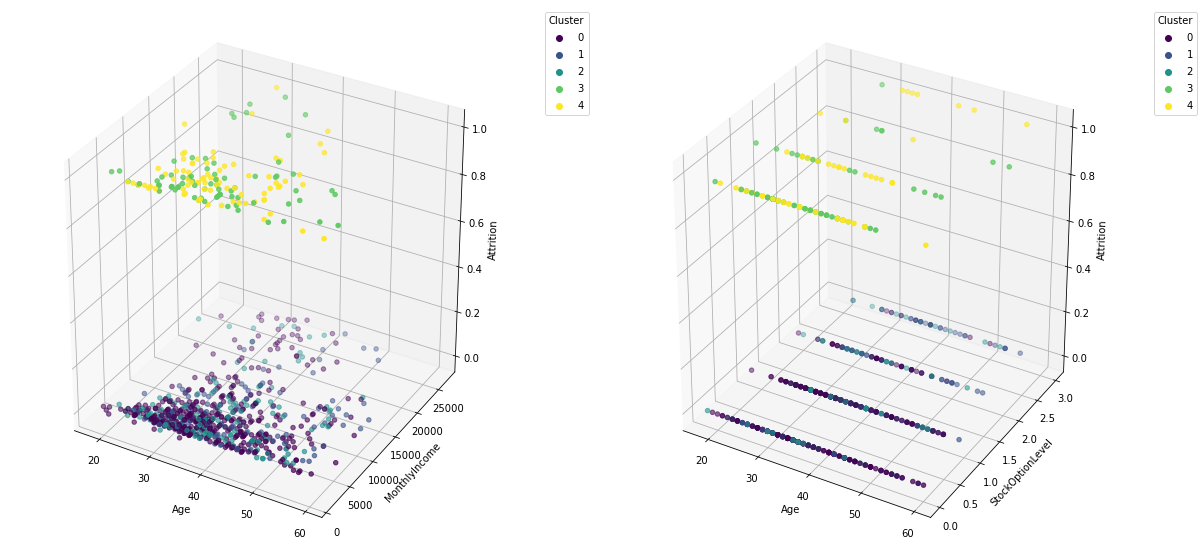

In [257]:
plot_3d_scatterplot(df_impunted, 'Age', 'MonthlyIncome', 'StockOptionLevel', True)

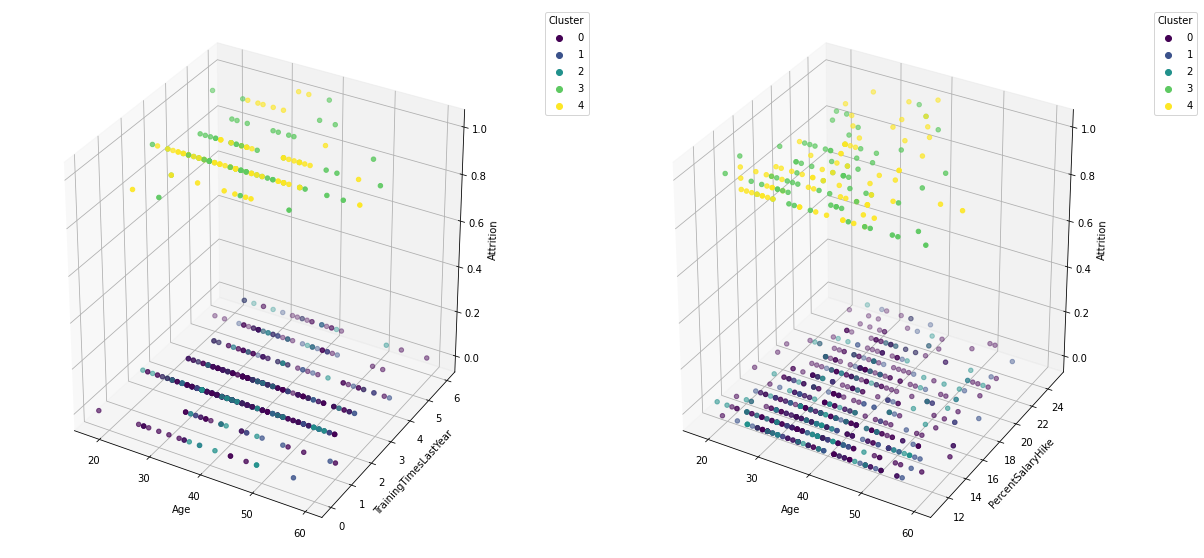

In [258]:
plot_3d_scatterplot(df_impunted, 'Age', 'TrainingTimesLastYear', 'PercentSalaryHike', True)

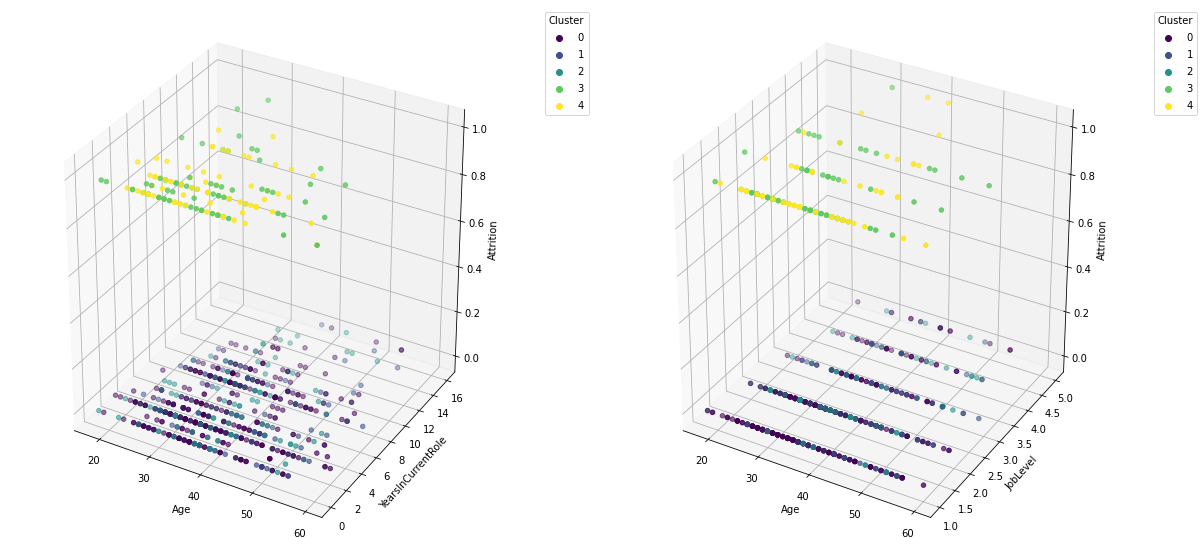

In [259]:
plot_3d_scatterplot(df_impunted, 'Age', 'YearsInCurrentRole', 'JobLevel', True)

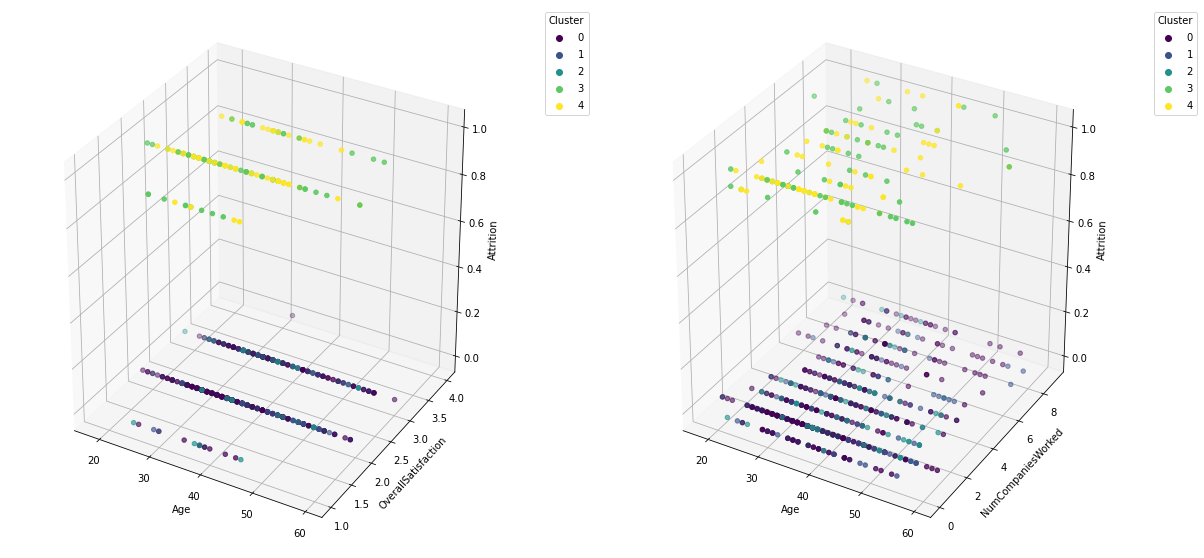

In [260]:
plot_3d_scatterplot(df_impunted, 'Age', 'OverallSatisfaction', 'NumCompaniesWorked', True)

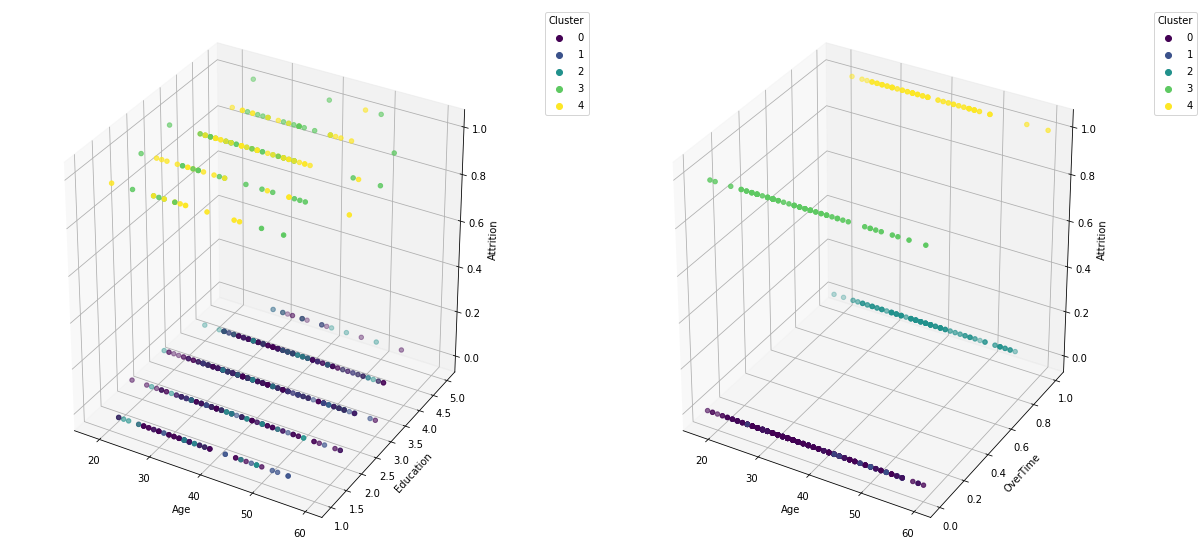

In [261]:
plot_3d_scatterplot(df_impunted, 'Age', 'Education', 'OverTime', True)

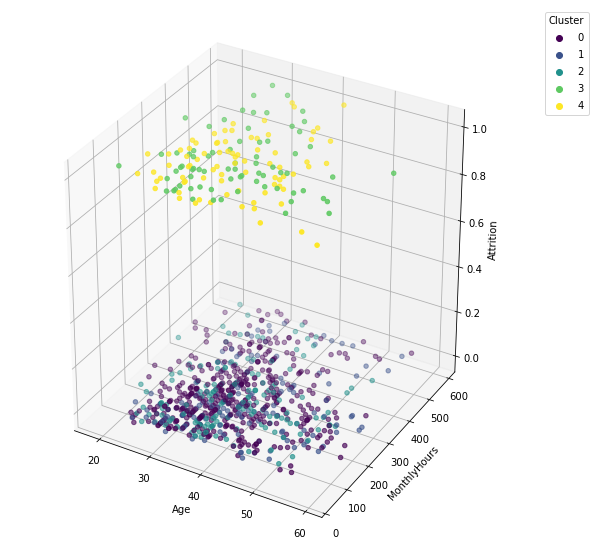

In [262]:
plot_3d_scatterplot(df_impunted, 'Age', 'MonthlyHours', "", False)

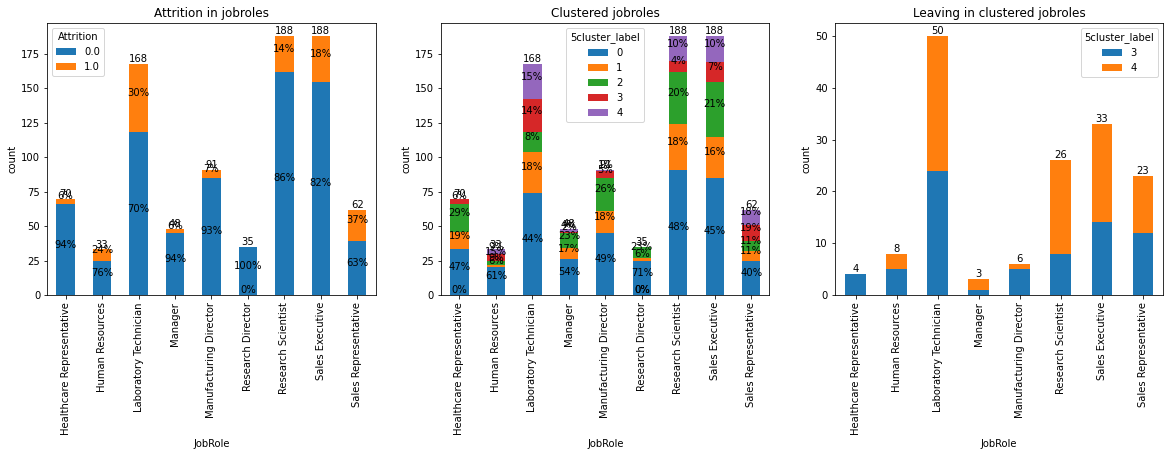

In [263]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "Attrition", df_impunted, df_num, True, ax, 90, "", "", "Attrition in jobroles")
ax = plt.subplot2grid(fig_dims, (0, 1))
draw_stacked_bar(curr_column, cluster_label, df_impunted,  df_num, True, ax, 90, "", "", "Clustered jobroles")
ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, cluster_label, df_impunted[df_impunted["Attrition"] == "Yes"], 
                 df_num[df_num["Attrition"] == 1], False, ax, 90, "", "", "Leaving in clustered jobroles")

<h6> Cluster 3 insight </h6>

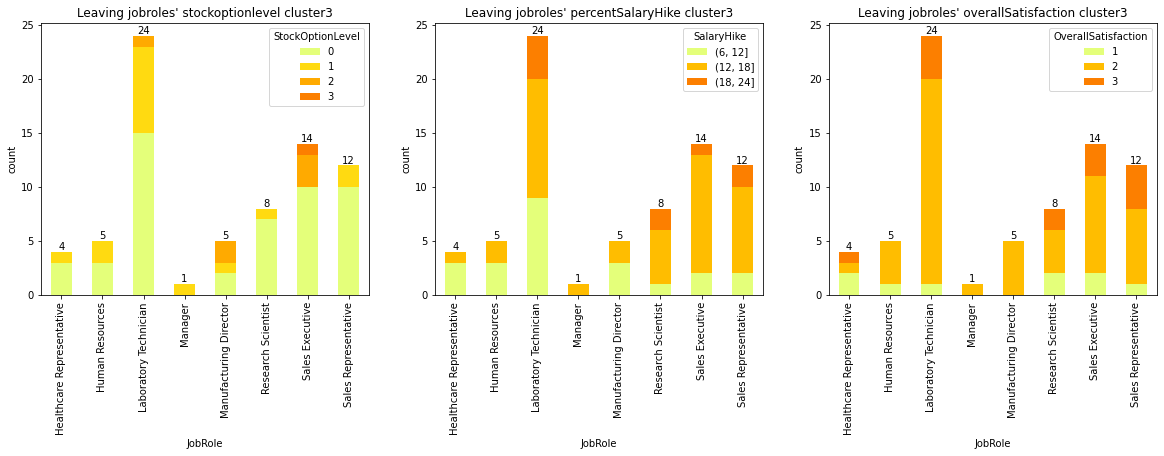

In [264]:
curr_column = "JobRole"
curr_cluster = 3
curr_cmap = "Wistia"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "StockOptionLevel", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"]=="Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' stockoptionlevel cluster" + str(curr_cluster))
 
ax = plt.subplot2grid(fig_dims, (0, 1))
df_hike = df_impunted.copy()
df_hike["SalaryHike"] = pd.cut(x=df_impunted["PercentSalaryHike"], bins=[6, 12, 18, 24])
draw_stacked_bar(curr_column, "SalaryHike", 
                 df_impunted[(df_impunted["Attrition"]=="Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_hike[(df_hike["Attrition"]=="Yes") & (df_hike[cluster_label]==curr_cluster)], 
                 False, ax, 90, "",curr_cmap, "Leaving jobroles' percentSalaryHike cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "OverallSatisfaction", 
                 df_impunted[(df_impunted["Attrition"]=="Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' overallSatisfaction cluster" + str(curr_cluster))

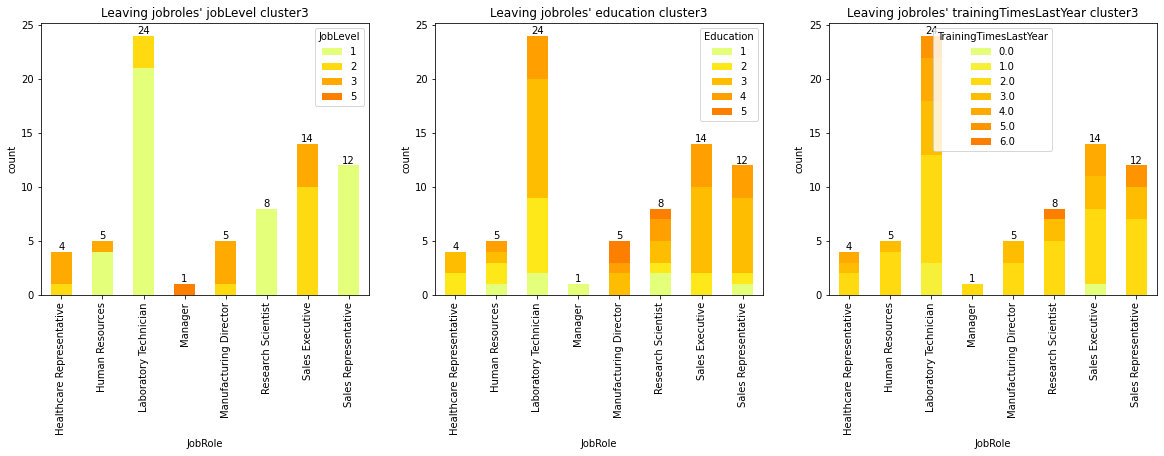

In [265]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "JobLevel", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)],
                False, ax, 90, "", curr_cmap, "Leaving jobroles' jobLevel cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 1))
draw_stacked_bar(curr_column, "Education", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                False, ax, 90, "", curr_cmap, "Leaving jobroles' education cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "TrainingTimesLastYear", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
    False, ax, 90, "upper center", curr_cmap, "Leaving jobroles' trainingTimesLastYear cluster" + str(curr_cluster))

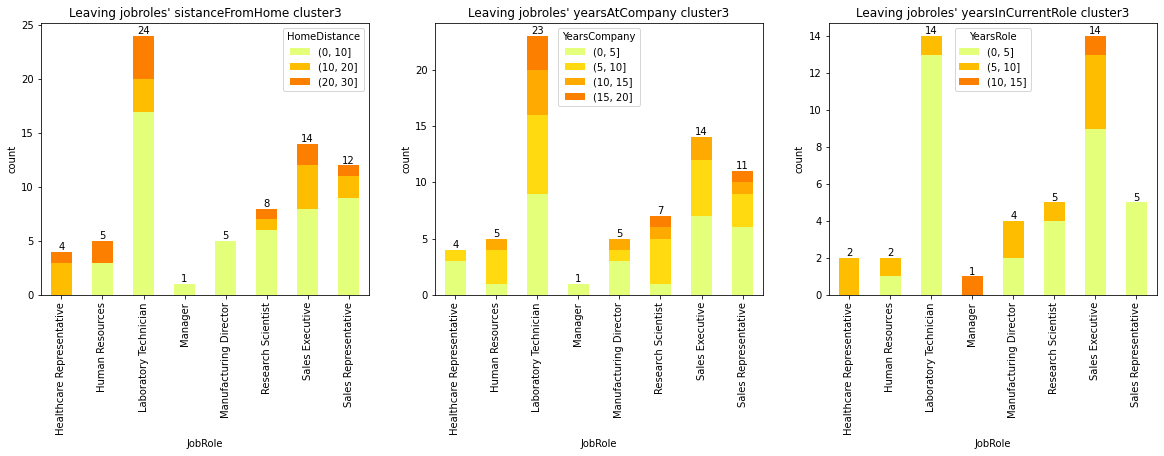

In [266]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
df_dist = df_impunted.copy()
df_dist["HomeDistance"] = pd.cut(x=df_impunted["DistanceFromHome"], bins=[0, 10, 20, 30])
draw_stacked_bar(curr_column, "HomeDistance", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_dist[(df_dist["Attrition"] == "Yes") & (df_dist[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' sistanceFromHome cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 1))
df_yc = df_impunted.copy()
df_yc["YearsCompany"] = pd.cut(x=df_impunted["YearsAtCompany"], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40])
draw_stacked_bar(curr_column, "YearsCompany", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_yc[(df_yc["Attrition"] == "Yes") & (df_yc[cluster_label]==curr_cluster)], 
         False, ax, 90, "upper center", curr_cmap, "Leaving jobroles' yearsAtCompany cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 2))
df_yr = df_impunted.copy()
df_yr["YearsRole"] = pd.cut(x=df_impunted["YearsInCurrentRole"], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40])
draw_stacked_bar(curr_column, "YearsRole", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_yr[(df_yr["Attrition"] == "Yes") & (df_yr[cluster_label]==curr_cluster)], 
    False, ax, 90, "upper center", curr_cmap, "Leaving jobroles' yearsInCurrentRole cluster" + str(curr_cluster))

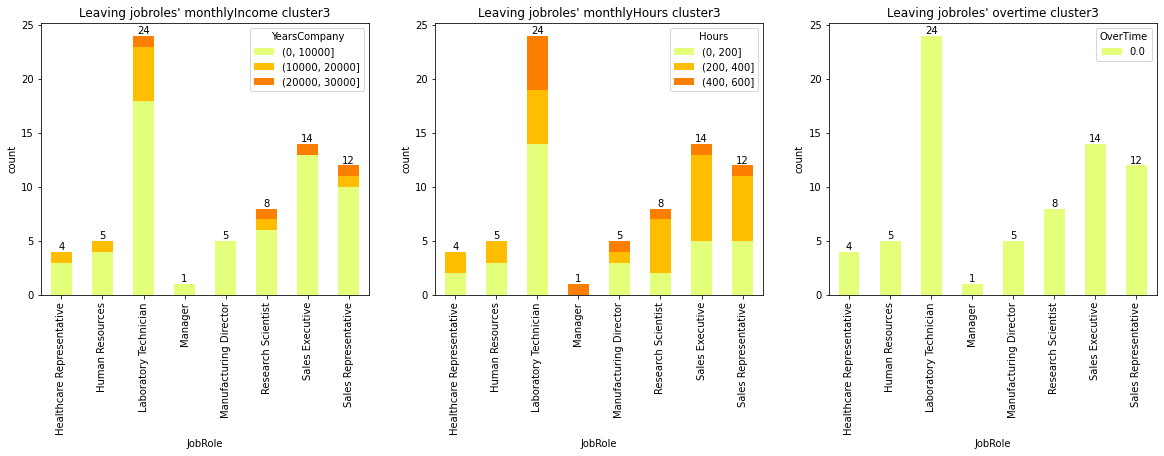

In [267]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
df_income = df_impunted.copy()
df_income["YearsCompany"] = pd.cut(x=df_impunted["MonthlyIncome"], bins=[0, 10000, 20000, 30000])
draw_stacked_bar(curr_column, "YearsCompany", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_income[(df_income["Attrition"] == "Yes") & (df_income[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' monthlyIncome cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 1))
df_h = df_impunted.copy()
df_h["Hours"] = pd.cut(x=df_impunted["MonthlyHours"], bins=[0, 200, 400, 600, 800, 1000])
draw_stacked_bar(curr_column, "Hours",
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_h[(df_h["Attrition"] == "Yes") & (df_h[cluster_label]==curr_cluster)],
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' monthlyHours cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "OverTime", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_num[(df_num["Attrition"] == 1) & (df_num[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' overtime cluster" + str(curr_cluster))

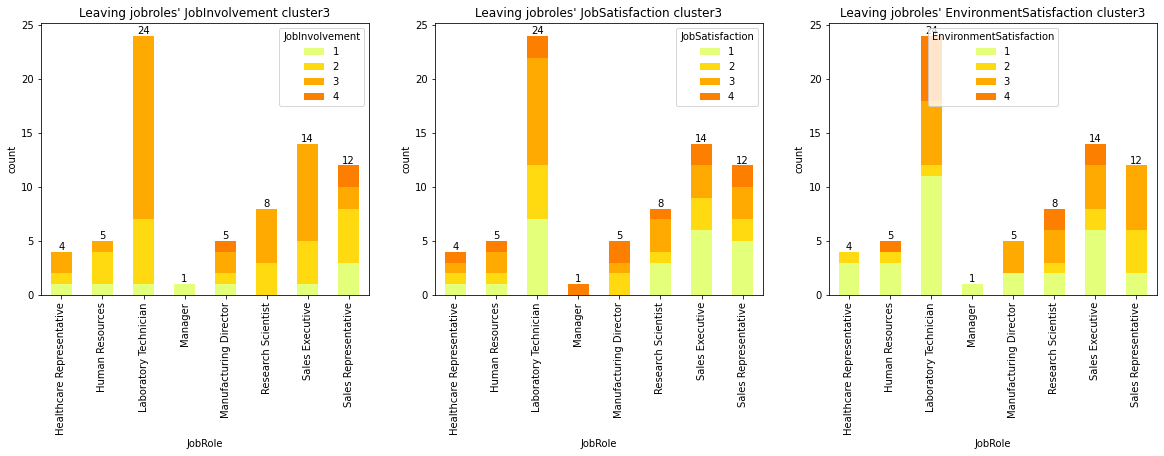

In [268]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "JobInvolvement", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap,
                                                 "Leaving jobroles' JobInvolvement cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 1))
draw_stacked_bar(curr_column, "JobSatisfaction", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)],
                 False, ax, 90, "", curr_cmap,
                                            "Leaving jobroles' JobSatisfaction cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "EnvironmentSatisfaction", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "upper center", curr_cmap,
                                         "Leaving jobroles' EnvironmentSatisfaction cluster" + str(curr_cluster))

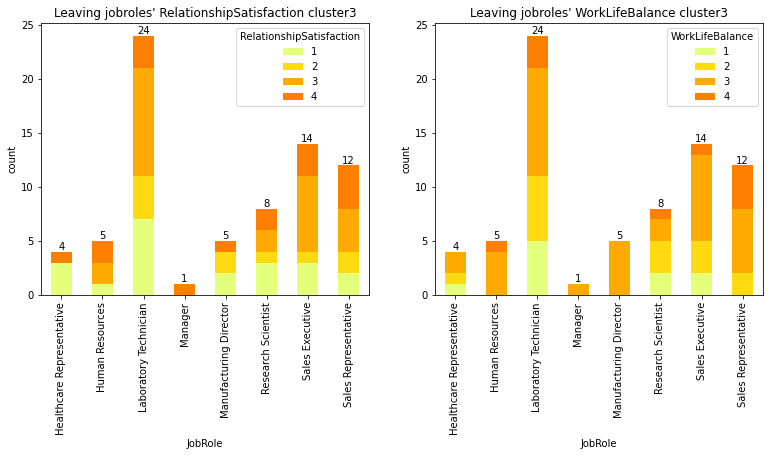

In [269]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "RelationshipSatisfaction", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap,
                                "Leaving jobroles' RelationshipSatisfaction cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 1))
draw_stacked_bar(curr_column, "WorkLifeBalance", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)],
                 False, ax, 90, "", curr_cmap,
                                         "Leaving jobroles' WorkLifeBalance cluster" + str(curr_cluster))

<h6> Cluster 4 insight </h6>

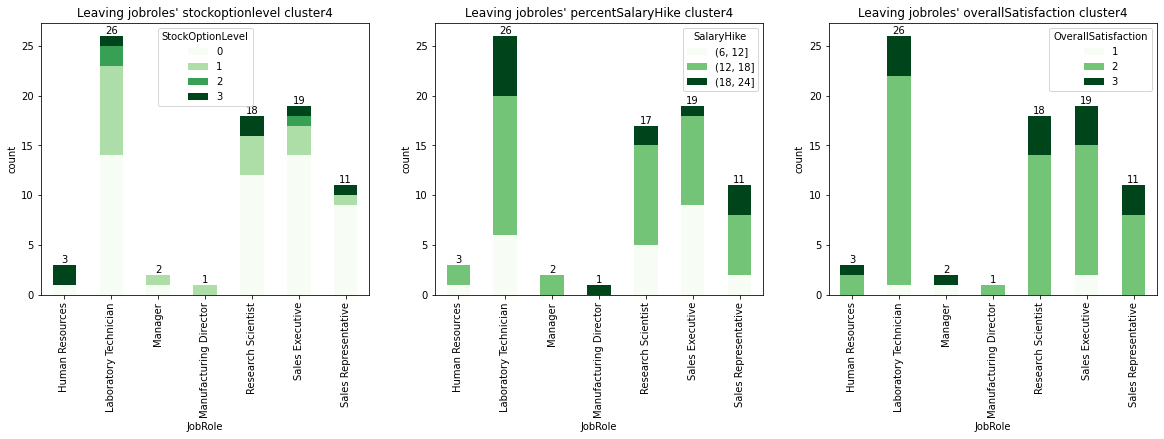

In [270]:
curr_column = "JobRole"
curr_cluster = 4
curr_cmap = "Greens"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "StockOptionLevel", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"]=="Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' stockoptionlevel cluster" + str(curr_cluster))
 
ax = plt.subplot2grid(fig_dims, (0, 1))
df_hike = df_impunted.copy()
df_hike["SalaryHike"] = pd.cut(x=df_impunted["PercentSalaryHike"], bins=[6, 12, 18, 24])
draw_stacked_bar(curr_column, "SalaryHike", 
                 df_impunted[(df_impunted["Attrition"]=="Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_hike[(df_hike["Attrition"]=="Yes") & (df_hike[cluster_label]==curr_cluster)], 
                 False, ax, 90, "",curr_cmap, "Leaving jobroles' percentSalaryHike cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "OverallSatisfaction", 
                 df_impunted[(df_impunted["Attrition"]=="Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' overallSatisfaction cluster" + str(curr_cluster))

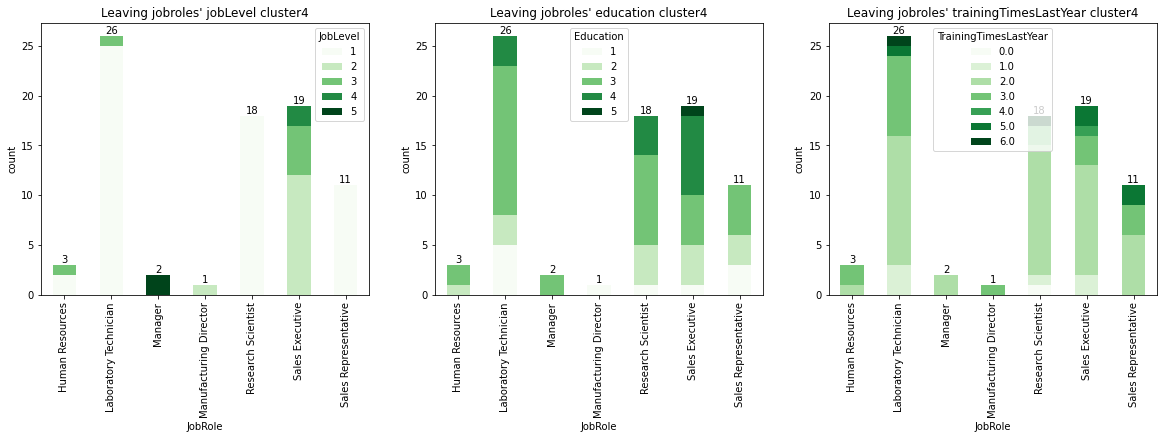

In [271]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "JobLevel", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)],
                False, ax, 90, "", curr_cmap, "Leaving jobroles' jobLevel cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 1))
draw_stacked_bar(curr_column, "Education", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                False, ax, 90, "", curr_cmap, "Leaving jobroles' education cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "TrainingTimesLastYear", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
    False, ax, 90, "upper center", curr_cmap, "Leaving jobroles' trainingTimesLastYear cluster" + str(curr_cluster))

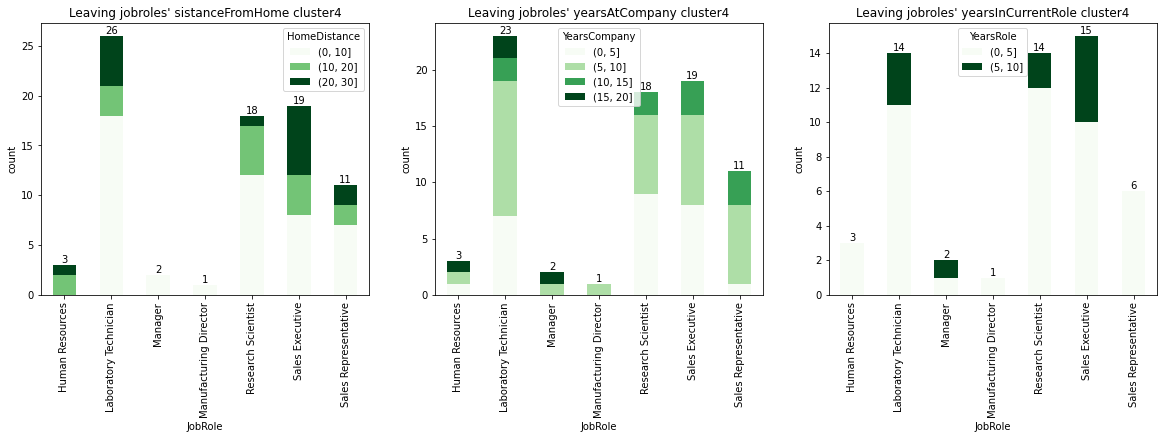

In [272]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
df_dist = df_impunted.copy()
df_dist["HomeDistance"] = pd.cut(x=df_impunted["DistanceFromHome"], bins=[0, 10, 20, 30])
draw_stacked_bar(curr_column, "HomeDistance", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_dist[(df_dist["Attrition"] == "Yes") & (df_dist[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' sistanceFromHome cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 1))
df_yc = df_impunted.copy()
df_yc["YearsCompany"] = pd.cut(x=df_impunted["YearsAtCompany"], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40])
draw_stacked_bar(curr_column, "YearsCompany", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_yc[(df_yc["Attrition"] == "Yes") & (df_yc[cluster_label]==curr_cluster)], 
         False, ax, 90, "upper center", curr_cmap, "Leaving jobroles' yearsAtCompany cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 2))
df_yr = df_impunted.copy()
df_yr["YearsRole"] = pd.cut(x=df_impunted["YearsInCurrentRole"], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40])
draw_stacked_bar(curr_column, "YearsRole", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_yr[(df_yr["Attrition"] == "Yes") & (df_yr[cluster_label]==curr_cluster)], 
    False, ax, 90, "upper center", curr_cmap, "Leaving jobroles' yearsInCurrentRole cluster" + str(curr_cluster))

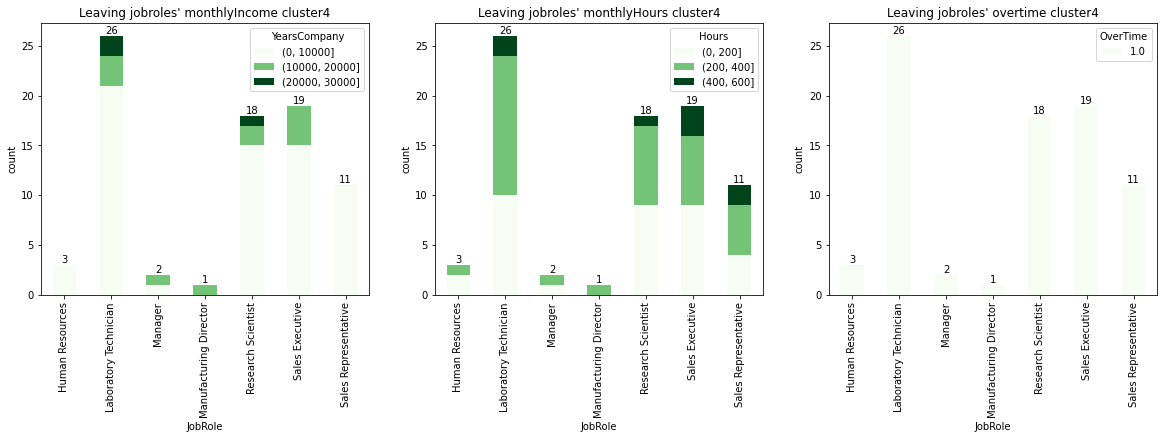

In [273]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
df_income = df_impunted.copy()
df_income["YearsCompany"] = pd.cut(x=df_impunted["MonthlyIncome"], bins=[0, 10000, 20000, 30000])
draw_stacked_bar(curr_column, "YearsCompany", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_income[(df_income["Attrition"] == "Yes") & (df_income[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' monthlyIncome cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 1))
df_h = df_impunted.copy()
df_h["Hours"] = pd.cut(x=df_impunted["MonthlyHours"], bins=[0, 200, 400, 600, 800, 1000])
draw_stacked_bar(curr_column, "Hours",
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_h[(df_h["Attrition"] == "Yes") & (df_h[cluster_label]==curr_cluster)],
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' monthlyHours cluster" + str(curr_cluster))

ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "OverTime", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_num[(df_num["Attrition"] == 1) & (df_num[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap, "Leaving jobroles' overtime cluster" + str(curr_cluster))

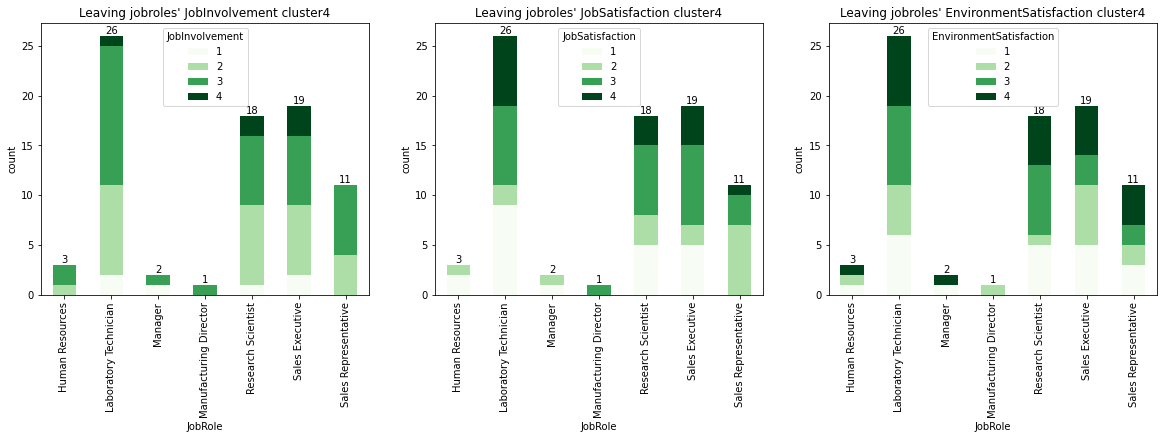

In [274]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "JobInvolvement", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap,
                                                 "Leaving jobroles' JobInvolvement cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 1))
draw_stacked_bar(curr_column, "JobSatisfaction", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)],
                 False, ax, 90, "", curr_cmap,
                                            "Leaving jobroles' JobSatisfaction cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 2))
draw_stacked_bar(curr_column, "EnvironmentSatisfaction", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "upper center", curr_cmap,
                                         "Leaving jobroles' EnvironmentSatisfaction cluster" + str(curr_cluster))

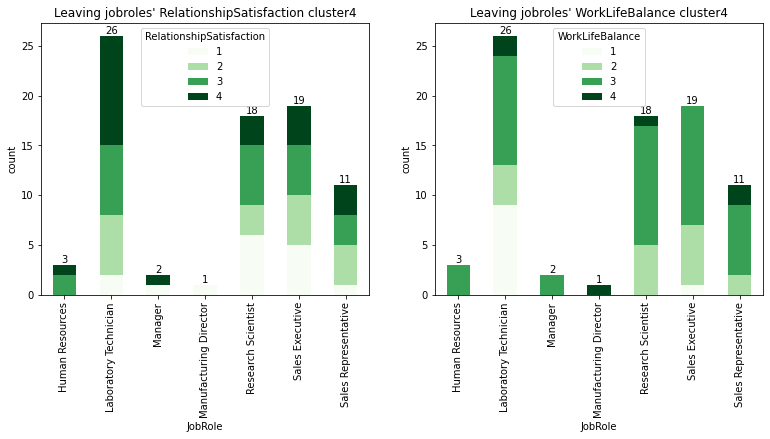

In [275]:
curr_column = "JobRole"
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
draw_stacked_bar(curr_column, "RelationshipSatisfaction", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 False, ax, 90, "", curr_cmap,
                                "Leaving jobroles' RelationshipSatisfaction cluster" + str(curr_cluster))
ax = plt.subplot2grid(fig_dims, (0, 1))
draw_stacked_bar(curr_column, "WorkLifeBalance", 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)], 
                 df_impunted[(df_impunted["Attrition"] == "Yes") & (df_impunted[cluster_label]==curr_cluster)],
                 False, ax, 90, "", curr_cmap,
                                         "Leaving jobroles' WorkLifeBalance cluster" + str(curr_cluster))